In [53]:
%reload_ext autoreload
%autoreload 2

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, plot_roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm
import pydotplus

%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=14)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this chapter we will **only talk about classification**. Classifiers associate a transformed set of features to a set of classes (a discrete variable)

![class_reg](../images/class_reg.png)

In this notebook we are going to focus on distance based classification method (opposed to decision tree for example wich works with threshold more than actual distances). The goal is to give you some insight on 4 different levels:
- **Best practices** 
- **Intuition on the concepts behind those methods**
- **How to implement them with Scikitlearn**
- **Intuition on the different parameters that your model need but are not trainable (hyperparameters)**

# Distance based classification method
## Table Of Content: <a id='toc'></a>

* [Meet the data](#data)
    * [Multiclass dataset : penguins identification](#data-penguin)
    * [Binary class dataset : breast cancer](#data-cancer)

* [Feature selection - univariate approach](#second-bullet)
    * [Exercise - feature selection](#exo-feature)

* [**K-nearest neighbors : introduction to basic routine in ML**](#neighbors)
    * [Toy dataset: KNN concepts and hyperparameters](#KN-concepts)
    * [Cancer dataset/introduction to metrics and ML concepts](#K-cancer)
        * [splitting the dataset : train and test sets](#split)
        * [a metric to score classification : accuracy](#accuracy)
        * [Hyper-parameters](#hyperparam)
    * [Exercise KNN](#MC-KN)
    
    
* [**Logistic regression and the ooportunity to use AUC ROC**](#Logistic-regression)
    * [Concepts: what is linear regression and introduction to regularization](#Logistic-regression)
    * [Breast cancer dataset](#LR-hyper)
    * [imbalanced dataset](#imbalanced)    
    * [Exercise : optimize an LR classifier hyper-parameters](#LR-cancerexo)
    * [LR with Multiclass](#MR-LR)
        * [LR on the penguin dataset](#LR-PENGUIN)
    
    
* [**Support Vector Machine**](#SVM)
    * [Concepts](#SVM)
    * [Toy dataset with linear kernel](#SVM-linear)
    * [Toy dataset with nonlinear kernel](#SVM-nonlinear)
    * [Cancer dataset: playing with the hyperparameters](#SVM-hyperparameters)
    
    
* [**Exercise**](#exo)

* [Appendix : Precision-Recall curves and alternative metrics](#PRcurve)


# Meet the data <a id='data'></a>

During this chapter we will play with two datasets and alternate demonstration and exercises on both.

[Back to the ToC](#toc)

## Multiclass dataset : penguins identification <a id='data-penguin'></a>

This dataset consists in data from 344 penguins grouped in three species :

![penguins](../images/lter_penguins.png)
*Artwork by @allison_horst*

[dataset source](https://allisonhorst.github.io/palmerpenguins/)


Among the columns present in there, we drop the ones, like `StudyID` or `sampleNumber` to keep only columns of potential interest for the task at hand :

In [55]:
df_penguin = pd.read_csv( "../data/horst2020_palmerpenguins_raw.csv" )

kept_columns = [ 'Species',  'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


## keep the nice doodle color code!
penguin_colors = {'Adelie':'#FF8C00',
                  'Chinstrap':"#A020F0",
                  'Gentoo':"#008B8B"}


df_penguin = df_penguin.loc[: , kept_columns ]
# keep only the first word of the species field. We do not need the latin name here
df_penguin.Species = df_penguin.Species.apply(lambda x: x.partition(' ')[0])
df_penguin.head()

Species Clutch Completion  Culmen Length (mm)  Culmen Depth (mm)  \
0  Adelie               Yes                39.1               18.7   
1  Adelie               Yes                39.5               17.4   
2  Adelie               Yes                40.3               18.0   
3  Adelie               Yes                 NaN                NaN   
4  Adelie               Yes                36.7               19.3   

   Flipper Length (mm)  Body Mass (g)     Sex  Delta 15 N (o/oo)  \
0                181.0         3750.0    MALE                NaN   
1                186.0         3800.0  FEMALE            8.94956   
2                195.0         3250.0  FEMALE            8.36821   
3                  NaN            NaN     NaN                NaN   
4                193.0         3450.0  FEMALE            8.76651   

   Delta 13 C (o/oo)  
0                NaN  
1          -24.69454  
2          -25.33302  
3                NaN  
4          -25.32426

The columns correspond to :

* **Species** : the penguin species
* **Clutch Completion** : if the study nest ws observed with a full clutch, i.e., 2 eggs
* **Culmen Length** : length of the dorsal ridge of a bird's bill (millimeters)
* **Culmen Depth** : the depth of the dorsal ridge of a bird's bill (millimeters)
* **Flipper Length** : the length of a bird's flipper (millimeters)
* **Body Mass** : the penguin body mass (grams)
* **Sex** : the sex of the animal
* **Delta 15 N** : measure of the ratio of stable isotopes 15N:14N
* **Delta 13 C** : measure of the ratio of stable isotopes 13C:12C

You can see there are some NAs. Let's throw away samples with Nas (only 20 of them):

In [56]:
K = df_penguin.isnull().sum(axis=1) < 1

df_penguin = df_penguin.loc[K,:]
df_penguin.shape

(324, 9)

In [57]:
df_penguin.Species.value_counts()

Adelie       139
Gentoo       118
Chinstrap     67
Name: Species, dtype: int64

In [58]:
## finally, we separate the target variable (Species) from the rest
y_penguin = df_penguin.Species

# here note the usage of pd.get_dummies to one-hot encode categorical data!
X_penguin = pd.get_dummies(df_penguin.drop( columns="Species" ), drop_first=True)

[Back to the ToC](#toc)

## Binary class dataset : breast cancer <a id="data-cancer"></a>

This time, no cute doodle, but maybe that is for the best.

In the cancer dataset you have 569 tumors for which many features have been measured. The goal is to predict if the tumor is malignant or not.

In [59]:
# the breast cancer dataset is integrated in the sklearn library
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

## we reduce the features because otherwise this problem is a bit too easy ;-)
m = list( map( lambda x : x.startswith("mean ") , data["feature_names"] ) )


X_cancer=data['data'][:,m]

# for some reason this dataset has encoded 0 for malignant,
# which is extremely counter intuitive
# So I choose to switch it to the more intuitive order now
y_cancer= 1-data['target']

#making it into a dataframe
df_cancer=pd.DataFrame(X_cancer,
    columns=data["feature_names"][m])

df_cancer["malignant"]=y_cancer

# 0 : benign
# 1 : malignant


df_cancer.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  malignant  
0                 0.07871          1  
1                 0.05667          1  
2                 0.05999          1  
3                 0.09744          1  
4                 0.05883          1

In [60]:
print('features:\n')
for s in df_cancer.columns:
    print(s)

features:

mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
malignant


In [61]:
df_cancer.malignant.value_counts()

0    357
1    212
Name: malignant, dtype: int64

So, there is a slight over-representation of benign tumors.

[Back to the ToC](#toc)

# Feature selection - univariate approach <a class="anchor" id="second-bullet"></a>

Feature selection serves three main purposes :

* reducing the computational cost of your model building and hypter-parameter exploration
* (sometimes) improve your model accuracy
* often makes your model more interpretable

Always need to be done in the context of domain expertise and subsequent goals.


A first good approach can be to look at your features correlations with the vairable of interest :

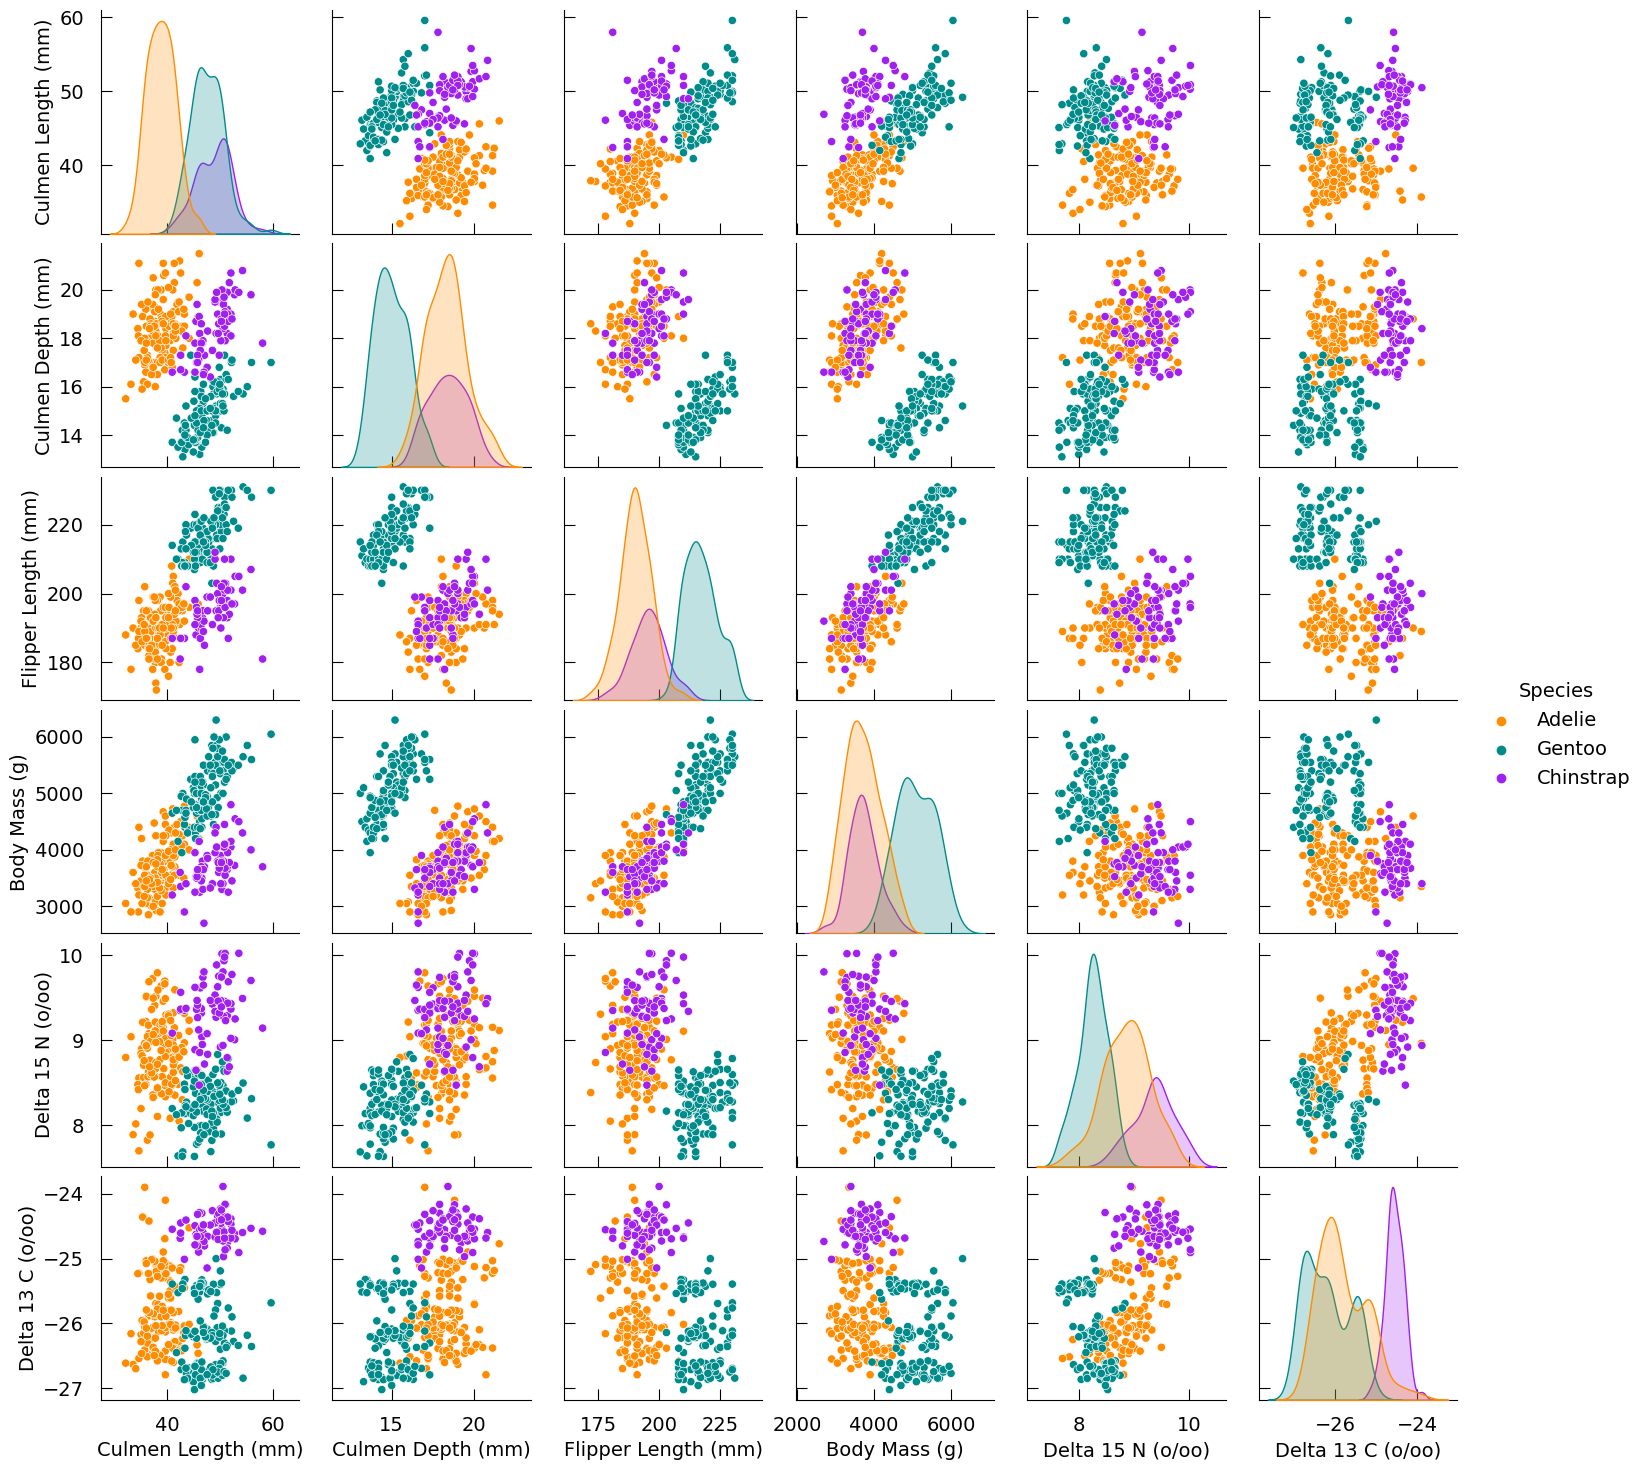

In [62]:
sns.pairplot(df_penguin , hue = "Species", palette=penguin_colors)

In [63]:
T1 = pd.crosstab( df_penguin.Species , df_penguin.Sex )
T2 = pd.crosstab( df_penguin.Species , df_penguin["Clutch Completion"] )
pd.concat([T1,T2], axis=1)

FEMALE  MALE  No  Yes
Species                         
Adelie         71    68  13  126
Chinstrap      34    33  14   53
Gentoo         58    60   7  111

One thing (among others) that you can do is to look for a **subset of features that seems to be important to describe the target class**. It's like the pairplots above but instead of just looking at it you choose the features you want to keep.

You can choose different metrics for "*how important to describe the class*" a feature is. Here , we present:


* **ANOVA-F** : F=$\frac{Var_{feature\_i}(Between\_class)}{Var_{feature\_i}(Within\_class)}$. 

> **F** : how much a feature $i$ variance is different between classes, normalized by the intrinsic variance of that feature per class. 
>
> So if **F** is big it means that the variation that you observe between classes is big compared to the variance of this feature : it behaves differently for different classes then it is a good feature to keep for the classification. 
>
> To this **F** is associated a **p-value** that you would use for scoring.


* Another score would be to use the amount of [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) shared between a feature and our target. The way this mutual information is caclulated is out of the scope of this class as it is a bit technical.


Once you have a metric for feature importance, `Scikit-learn` lets you specify a threshold on the features that are kept, either as:
* a direct number: `SelectKBest`.
* important features from a percentile of your top importance score: `SelectPercentile`.
* an error type: `SelectFpr` or `SelectFdr` (we will introduce the FPR and FDR later in this chapter).



In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# Creating the object SelectKBest and settling for 2 best features (k=2) 
# in term of chi2 score
skb = SelectKBest(f_classif, k=2)
skb.fit(
    X_penguin, 
    y_penguin)#calculating the ANOVA-F for each features

#all the features and the F pvalues associated. use .pvalues_
dico_pval={X_penguin.columns[i]:v for i,v in enumerate(skb.pvalues_)}
sortedPvals = sorted(dico_pval.items(), key=lambda x: x[1], reverse=False) 

print("features ANOVA-F scores (p-values):")
for feature,pval in sortedPvals:
    print('\t',feature , ':' , pval )

print("selected best:" , X_penguin.columns[ skb.get_support() ] )
    
X_new=skb.transform( X_penguin )# keep only the k=2 best features according to the score

print("New data with only the k=2 best features kept :")
print(X_new[:5,]) #printing only the 5 first entries
print('...')

features ANOVA-F scores (p-values):
	 Flipper Length (mm) : 3.1132608937673917e-104
	 Culmen Length (mm) : 2.64981456867204e-85
	 Culmen Depth (mm) : 2.9212676125568046e-79
	 Body Mass (g) : 4.227912040265332e-79
	 Delta 13 C (o/oo) : 7.397571652060372e-61
	 Delta 15 N (o/oo) : 4.423389484397718e-59
	 Clutch Completion_Yes : 0.0049904611447730675
	 Sex_MALE : 0.9510827498224892
selected best: Index(['Culmen Length (mm)', 'Flipper Length (mm)'], dtype='object')
New data with only the k=2 best features kept :
[[ 39.5 186. ]
 [ 40.3 195. ]
 [ 36.7 193. ]
 [ 39.3 190. ]
 [ 38.9 181. ]]
...


That would reduce our dataset to :

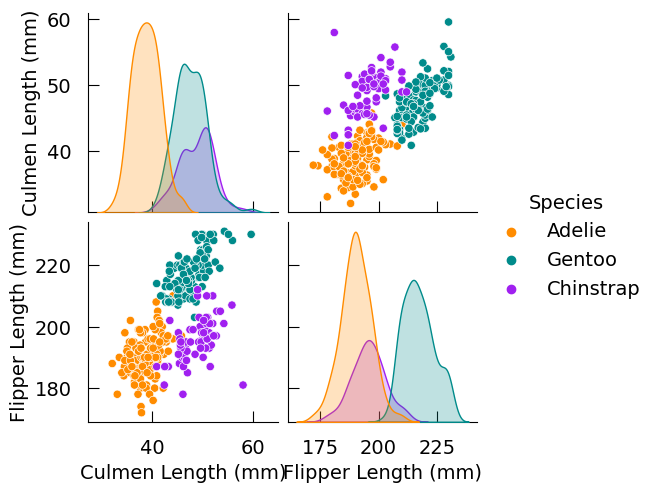

In [65]:
sns.pairplot( df_penguin , hue = "Species", palette=penguin_colors , vars = X_penguin.columns[ skb.get_support() ] )

**micro-exercise :** Does keeping these two specific feature look like a good idea for our species classification problem ? Why ?

<br>
<br>

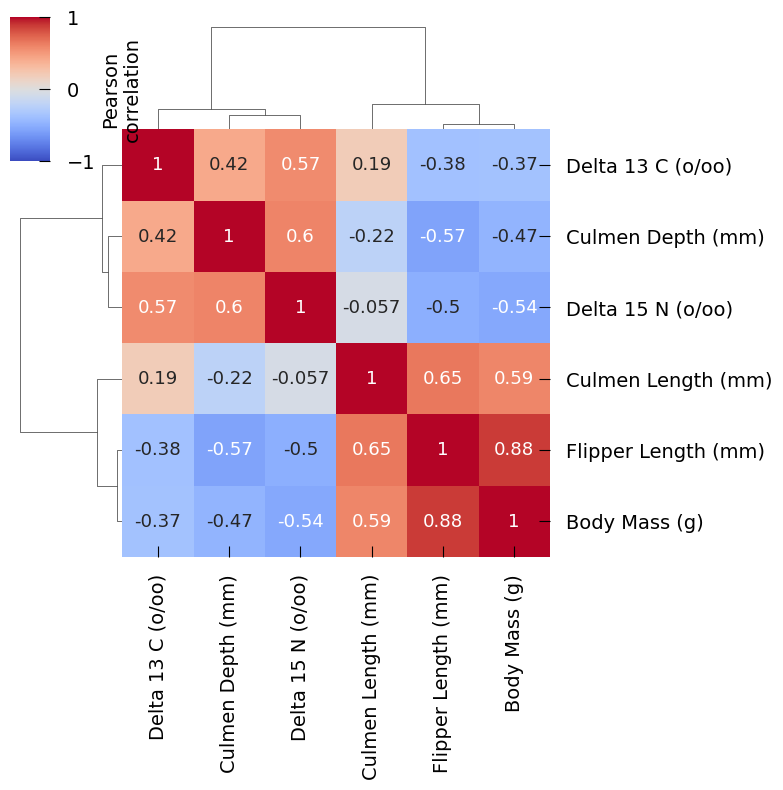

In [66]:
df_penguin_corr = df_penguin.corr()

sns.clustermap(df_penguin_corr,
               figsize=(8,8),
               z_score=None,
               row_cluster=True,
               col_cluster=True,
               method='ward',
               cmap='coolwarm',vmax=1,vmin=-1, 
               annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})
## sns allows you to do a hierarchical clustering that simply
plt.show()

The above pearson correlation matrix is highly informational. 

It allows you to see that **some variables are probably redundant** and so you don't need to have all of them, hence reducing the complexity of your model. 

Moreover it is usually bad to have highly correlated variables in your model since it is making it unstable and less interpretable. 

**micro-exercise :** what could we use to handle/mitigate this problem ?

[Back to ToC](#toc)

## Exercise - feature selection <a id="exo-feature"></a>

Look at interaction between features for the cancer datatset. What are the best features to keep to perform classification on tumor malignancy here (`y_cancer` or `df_cancer.malignant`) ?


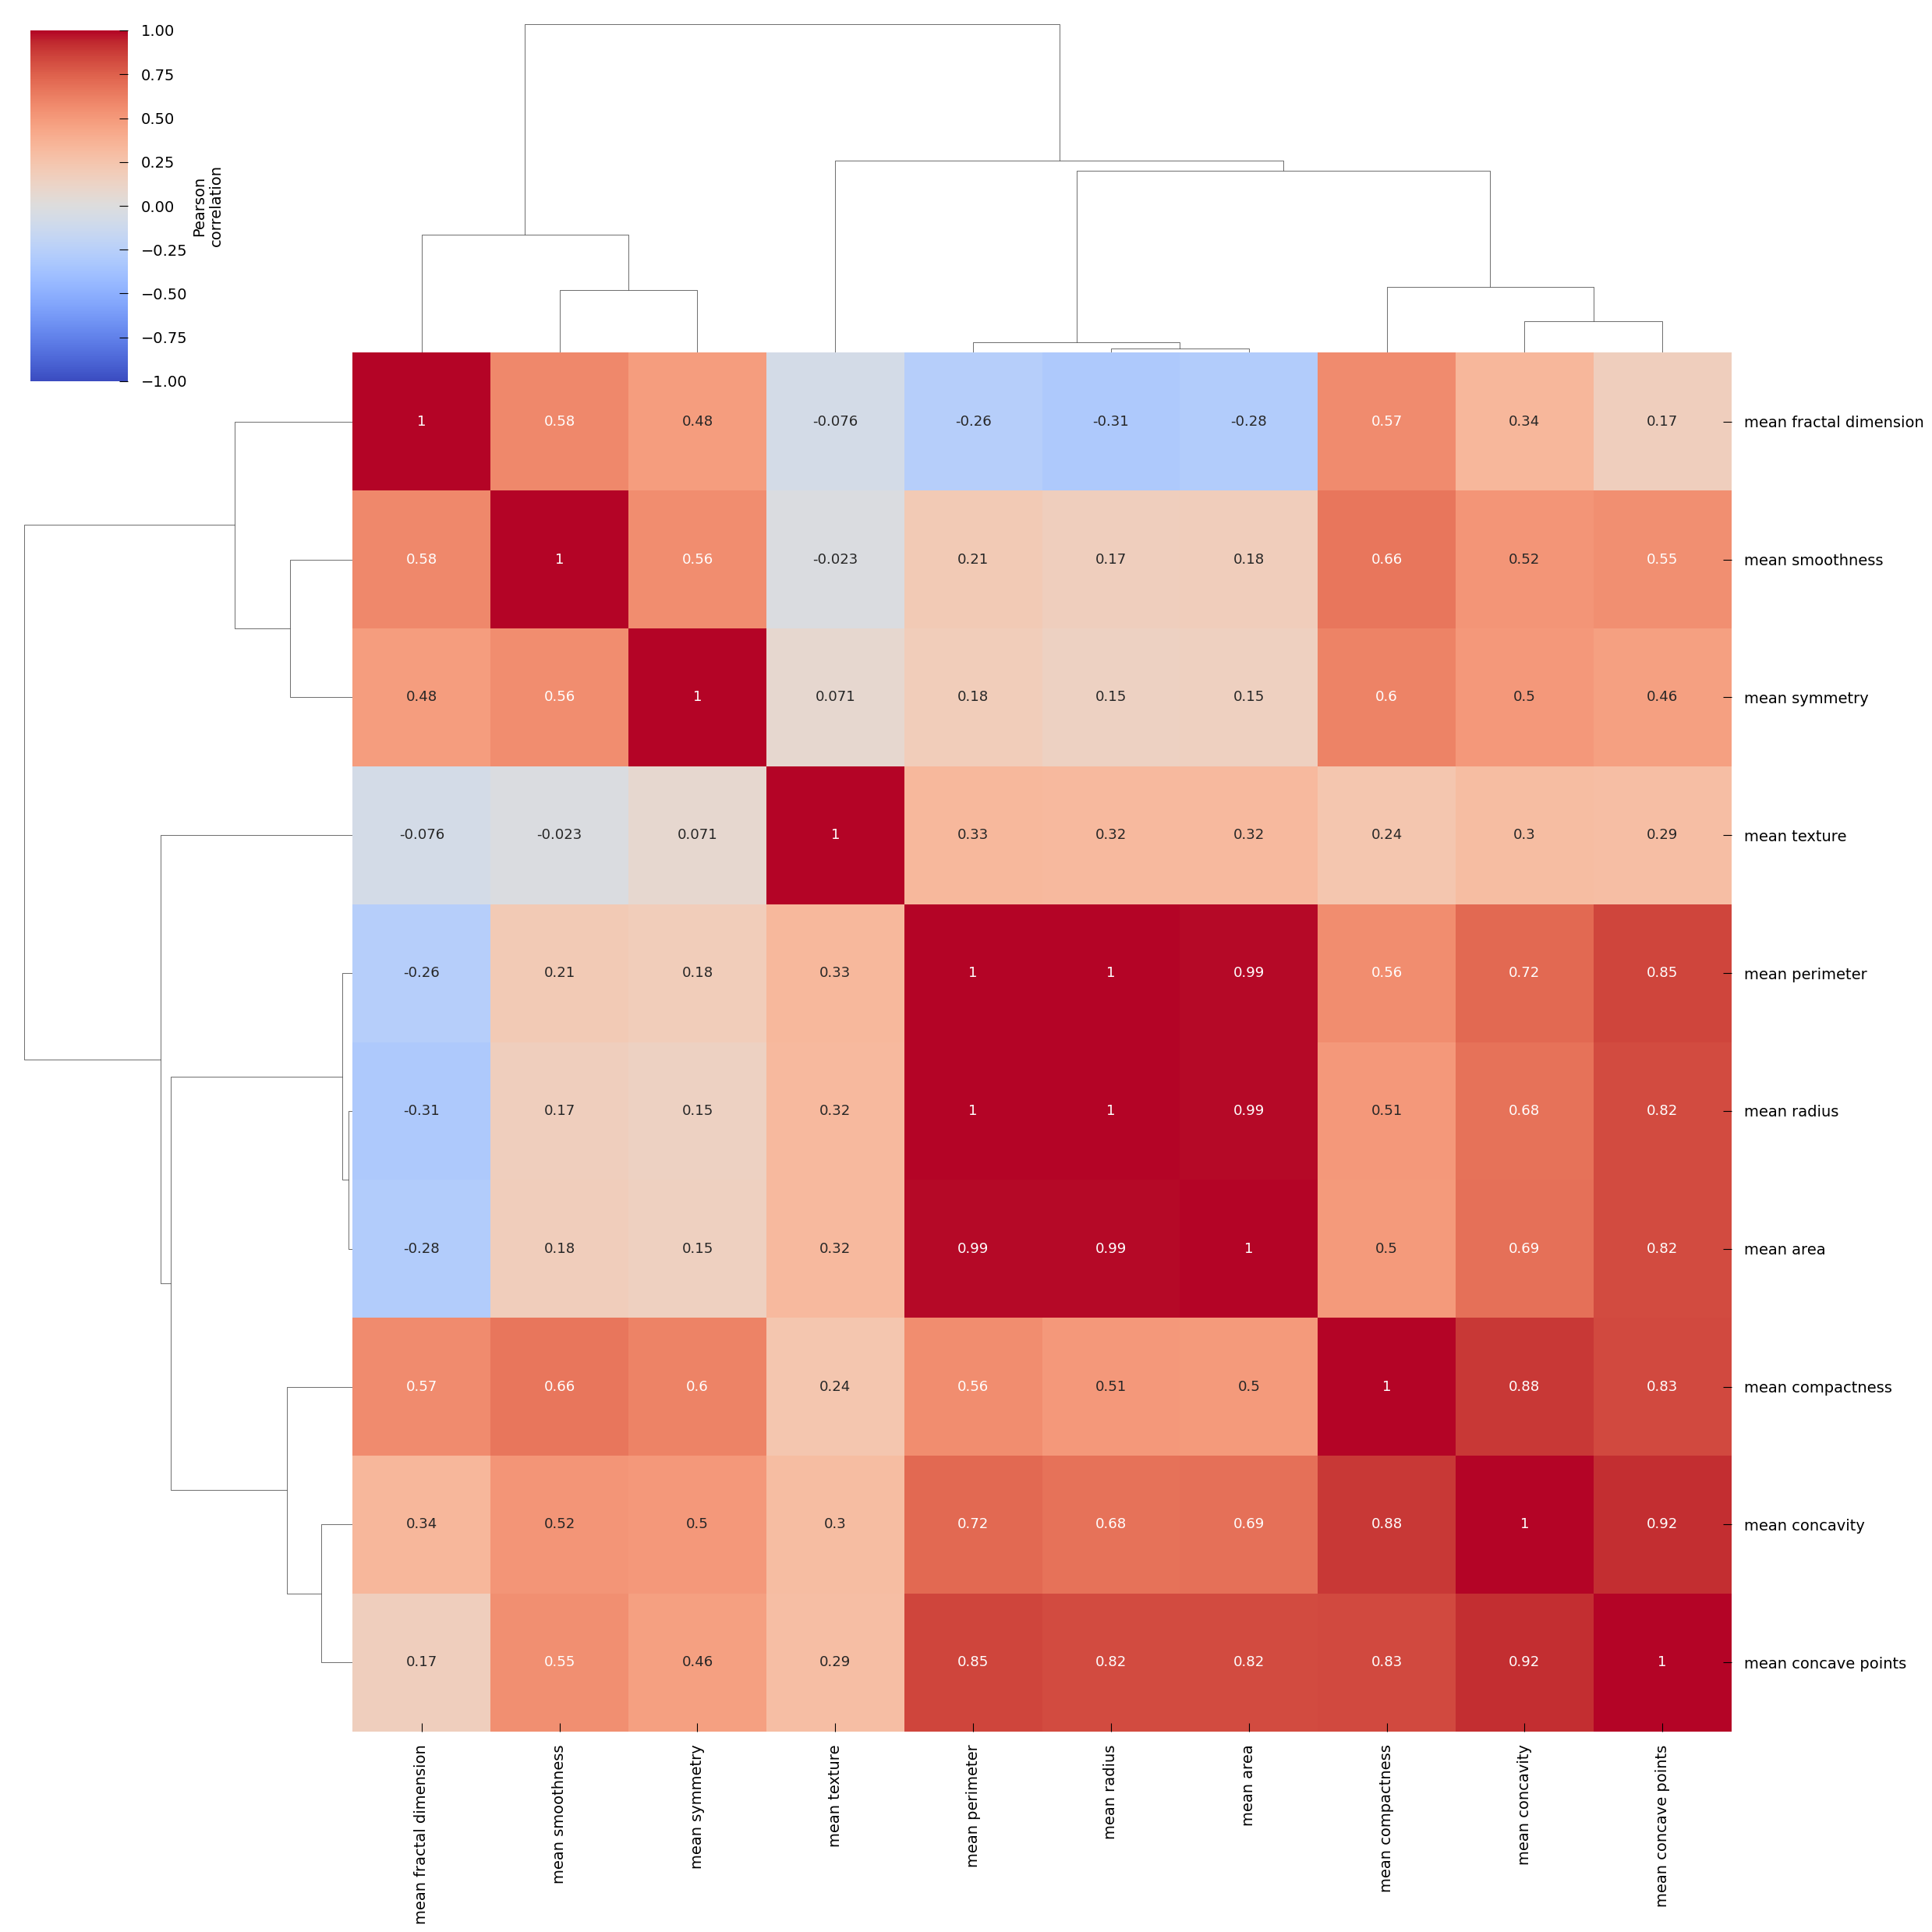

In [67]:
df_cancer_corr = df_cancer[list(df_cancer.columns)[:-1]].corr()

sns.clustermap(df_cancer_corr,figsize=(25,25),z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm',vmax=1,vmin=-1, annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})

plt.show()

In [68]:
# %load -r -24 solutions/solution_02_FS.py

In [69]:
# %load -r 25-26 solutions/solution_02_FS.py

In [70]:
# %load -r 29-40 solutions/solution_02_FS.py

In [71]:
# %load -r 42-63 solutions/solution_02_FS.py

In [72]:
# %load -r 65-74 solutions/solution_02_FS.py

In [73]:
# %load -r 75- solutions/solution_02_FS.py

Next we are going to use the cancer dataset again and even though what we just did above (PCA and feature selection) is truly best practice, for better interpretability and pedagogy we will keep the initial features untouched.

For the same pedagological reason and simplifying reasons we are going to keep all the features for the penguins dataset too. But you will see that for big dataset later on we might not have a choice : so keep all of the above in mind when you wil be confronted to real data.

[Back to ToC](#toc)

# K-nearest neighbors +  some basic routine <a class="anchor" id="neighbors"></a>

K-nearest neighbors is a pretty simple algorithm in terms of concept but it already has few hyperparameters that you should  understand and try to optimize. It will introduce you to some of the very experimental like routine that machine learning is.

For a classifier, k-nearest neighbors works as follow. 

**First the algorithm simply saves the labels that it is given during the training phase**. 

Then during the testing phase it takes a testing point and checks its `n_neighbors` nearest neighbors. 

**If `n_neighbors` nearest neighbors are mostly (in majority) from one label then the tested point will be assigned this label**. 

The way the `n_neighbors` **nearest neighbors vote** can be either 

 * uniform (every point as the same importance in the vote) or,
 * distance-based (a point distant to the tested point by a distance d will have a weight of 1/d in the vote).

![knn](../images/knn.png)

[Image from datacamp tutorials](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)

[Back to the ToC](#toc)

### Toy dataset: KNN concepts and hyperparameters<a class="anchor" id="KN-concepts"></a>

In [74]:
#Let's make some toy dataset. Here using the sklearn function making blobs for you!!!

from sklearn.datasets import make_blobs

# 120 points, 3 blobs/clusters with some spread=3
X_3, y_3 = make_blobs(n_samples=120, 
                      centers=3,
                      cluster_std=[[1,3],[1,3],[1,3]], random_state=6)

#Random_state is here just to be sure that every time you will get the same blobs. 
# If you change the random_state or do not
# specify it then you will get a new plot every time you call the function (random seed)

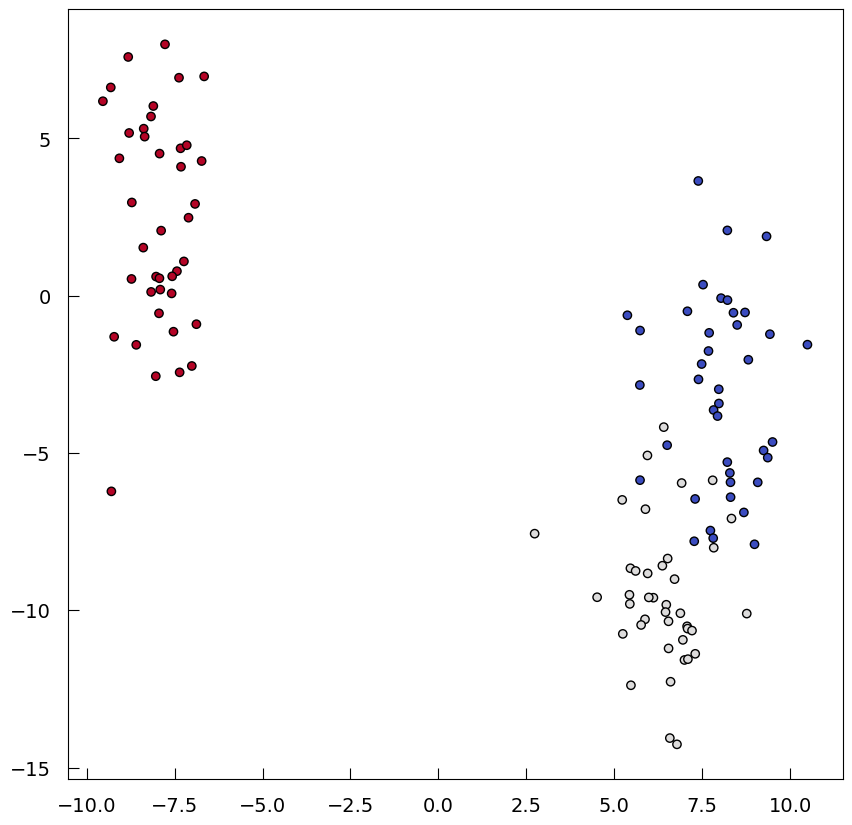

In [75]:
plt.scatter(X_3[:,0],X_3[:,1],c=y_3,cmap=plt.cm.coolwarm,edgecolors='k')
plt.show()

In [76]:
## install pydotplus if that is not already done
#!pip install pydotplus

<AxesSubplot:title={'center':'K neighbors k=1, uniform'}>

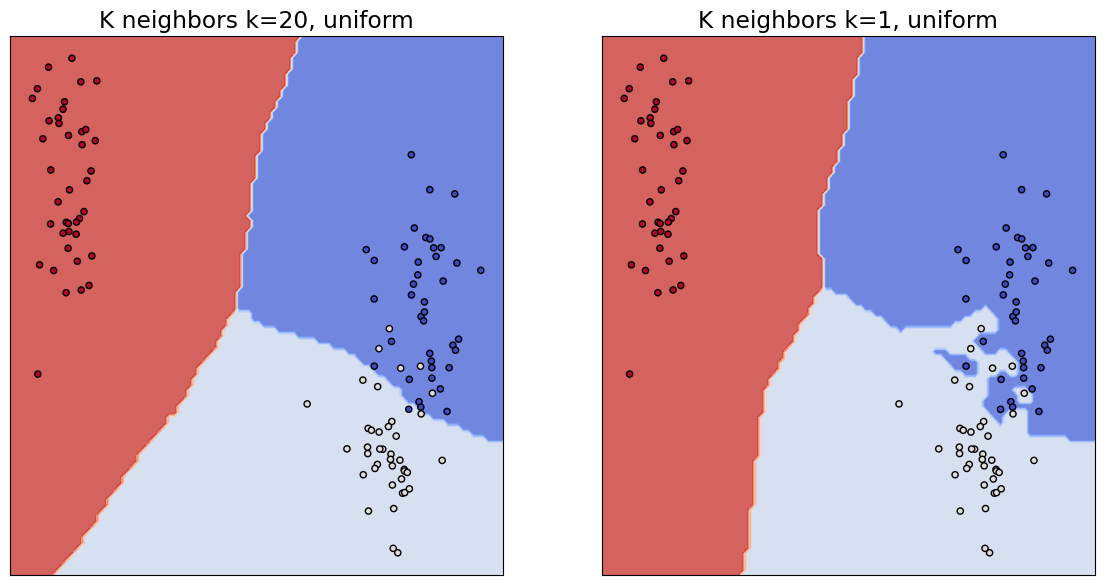

In [77]:
import pydotplus
from utils import contour_knn
fig,axes = plt.subplots(1,2,figsize=(14,7))

## 20 neighbors
contour_knn(20,X_3,y_3,'uniform', ax=axes[0])

## 1 neighbors
contour_knn(1,X_3,y_3,'uniform', ax=axes[1])

In the above we varied the number of voters (neighbors) to decide weither a point is from one class or another. You can see how the **boundaries are way more wiggly and attentive to missclassification when the number of neighbors is low**. But you can also imagine that if **new data is added those kind of too specific boundaries are going to missclassify the new points. This is a first example of this bias variance trade off.**

<AxesSubplot:title={'center':'K neighbors k=1, distance'}>

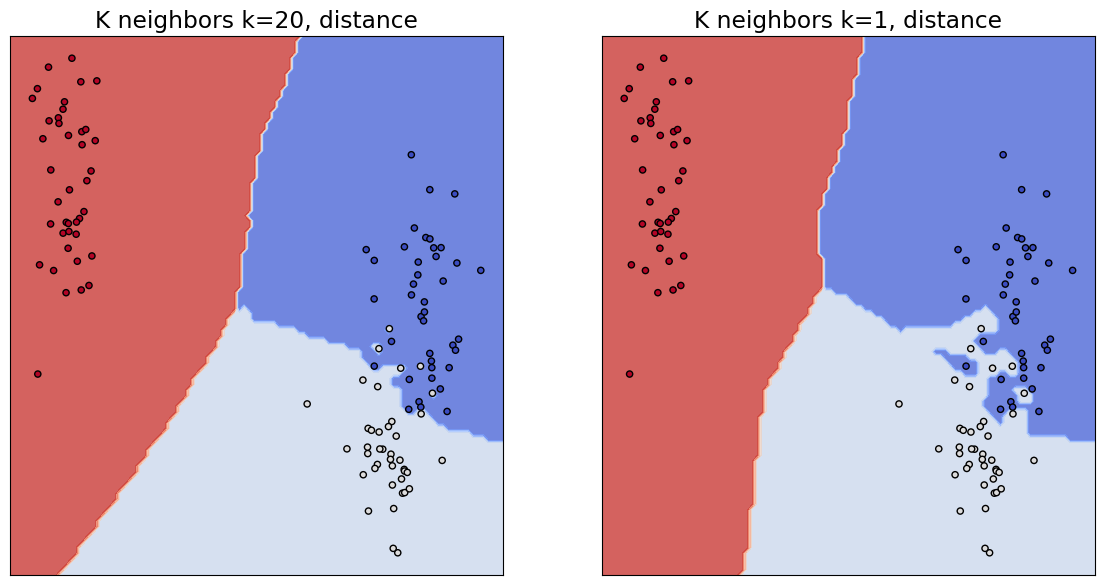

In [78]:
fig,axes = plt.subplots(1,2,figsize=(14,7))

contour_knn(20,X_3,y_3,'distance', ax=axes[0])
contour_knn(1,X_3,y_3,'distance', ax=axes[1])

Another parameter is how voting is done. Of course for only 1 neighbors this is the same graph as before. But for 20 neighbors you can see islands of white in the blue territory : again, overfitting.

[Back to the ToC](#toc)

## Cancer dataset/introduction to metrics and ML concepts <a class="anchor" id="K-cancer"></a>

### splitting the dataset : train and test sets <a class="anchor" id="split"></a>

**We will have to divide our data set into a train and a test set**. 

![train_test](../images/train_test.png)


The **test set should never be touched until the last step which is the model evaluation**. By doing so we can be confident that our evaluation of the **ability of our model to generalize to new data** is as fair as it can be 

We say that no information coming from the test set should leak into the train set. If this is the case, we are biasing our understanding of the generalizability of our model. 
To avoid **leakage** you should ensure your test set is absent from even the early stages of your pipeline, such as imputation or feature selection (so you have guessed it, most of the operations we have done until now have lead to leakage...).


In [79]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, 
                                                                                y_cancer,
                                                   random_state=7,stratify=y_cancer) 

# train_test_split stratify make sure to split the data such 
# that the two partitions ressemble each other statistically speaking
# For example a bad splitting would be that your training set have 
# 99% of one label and your testing set 99% of the other....

## Let's create a simple KNN classifier:
Kneighbors = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors.fit(X_cancer_train, y_cancer_train)

# the .score() function takes data and the correct label and give a "score"
score_train = Kneighbors.score(X_cancer_train,y_cancer_train)
score_test = Kneighbors.score(X_cancer_test,y_cancer_test)

print('Acc= {0:.3f} on train, Acc= {1:.3f} on test'.format(score_train,\
                                                           score_test))

Acc= 0.899 on train, Acc= 0.881 on test


So far I haven't defined a way to measure the quality of our classifier. Spoiler alert it is what is above called Acc for **Accuracy**. 

Accuracy is just the fraction of correctly labeled points.


However,we have a more urgent problem here: in the previous example we didn't rescale the data! **It can be really important to rescale your data mainly when the method you are using are based on distances (scalar product) or similarity** (remember the PCA, where we discussed this phenomenon). 

As the K-neighbors method is distance-based, and our various columns operate on different scale, we will rescale our data:

In [80]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler() #(X-mean(X))/std(X)
scaler.fit(X_cancer_train)
# the scaler is fit only on the train data!!!!!!!! 
# Doing it on the full data set is a perfect case of
# data leakage : you are going to provide a mean and a standard deviation 
# calculated with data containing the test set and 
# that's enough to bias your understanding of the model.

# Thus, you should always rescale data AFTER the splitting
X_cancer_train_scaled = scaler.transform(X_cancer_train)

# Now we scale the test set with the scaler fitted on the train set only
X_cancer_test_scaled = scaler.transform(X_cancer_test)


Kneighbors_scaled = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors_scaled.fit(X_cancer_train_scaled, y_cancer_train)

# computing our scores 
score_train = Kneighbors_scaled.score(X_cancer_train_scaled,y_cancer_train)
score_test = Kneighbors_scaled.score(X_cancer_test_scaled,y_cancer_test)

print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(score_train,\
                                                           score_test))


Acc= 0.960 on scaled train, Acc= 0.937 on scaled test


You can see that now that we have performed scaling our accuracy has improved: from 0.899 to 0.960 on the train set. 

> Note : Here note that even though I computed the accuracy on the test set, I **use an improvement in train set accuracy to decide** between using scaled data. Otherwise, I would have a form a leakage here! Yes, leakage is a perfidious thing.

[Back to the ToC](#toc)


### a metric to score classification : accuracy <a id="accuracy" ></a>

One straight forward metric to evaluate our model is the accuracy. Accuracy is only interesting on the test set, even though it can give you some good insight about your model when accuracy is compared between test and training set. 

But again, the main thing that is going to matter to evaluate your model concern metric evaluated on the test set.


Accuracy is defined as follow : $\frac{TP+TN}{P+N}$

* TP : True Positive
* TN : True Negative
* FP : False Positive
* FN : False Negative
* P : Positive : $P=TP+FN$
* N : Negative : $N=TN+FP$


[Back to the ToC](#toc)

### Hyper-parameters <a id="hyperparam"></a>

#### Partition size

let's continue working on the cancer dataset

As introduced before we split data into a training set and a test dataset. Let's see how the **partition size** can affect our model learning.

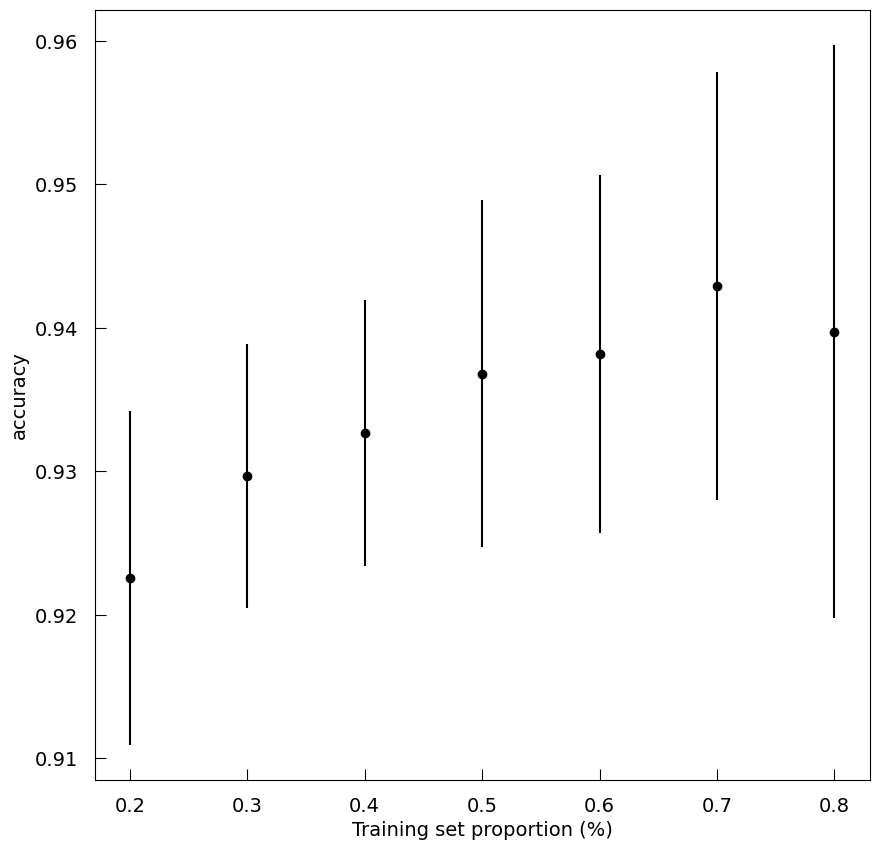

In [81]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform',n_jobs=-1)

plt.figure()

for s in t:

    ## for each partition size 
    # we will split the dataset randomly 100 times to assess the effect
    scores = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_cancer, 
                                                            y_cancer, 
                                                            test_size = 1-s, 
                                                            stratify=y_cancer)
        scaler = StandardScaler() 
        scaler.fit(X_train) 

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        knn.fit(X_train_scaled, y_train)
        scores.append(knn.score(X_test_scaled, y_test))
    plt.errorbar(s, np.mean(scores),yerr=np.std(scores),c='k',marker='o')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

Of course if your training dataset is too small it is not going to be representative of the whole dataset and your accuracy on the test set is going to be small. 

The bigger the training set proportion, the better the chance of recapitulating the whole dataset. However this proportion should not be too big either because you still want a significant part of your dataset to be unseen for evaluating your model.

#### number of neighbors

Let's see how the number of neighbors actually influence the accuracy of our model. So far we just put some random values for this parameter. First with the `'uniform'` voting weights:

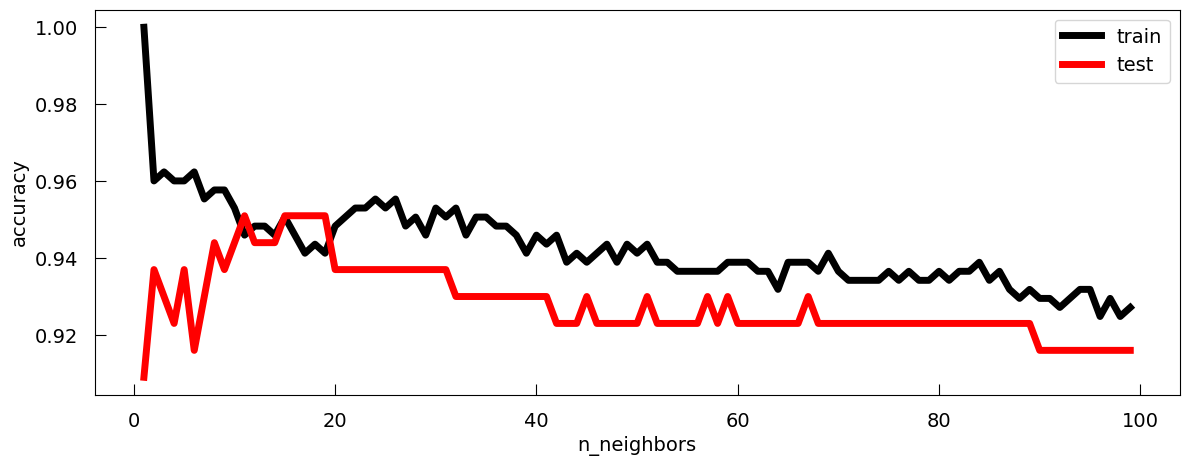

In [82]:
k_range = range(1,100)
scores_test = []
scores_train = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform',n_jobs=-1)
    knn.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(knn.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(knn.score(X_cancer_train_scaled, y_cancer_train))

plt.figure(figsize=(14,5))
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

The train set accuracy decreases with the number of neighbors involved in the vote. For very small values of `n` we are clearly overfitting : accuracy at 1 for the training set and a big drop in the accuracy of the test set.

<br>

**But**, using this sort of curve to decide on a reasonable value for the number of neighbors  is leakage again : the test set is informing our decision with respect to our models...

We need a method to be able to evaluate our model, in particular avoid overfitting, that does not rely on the test set.

#### Exploring and choosing in the hyperparameter space : ML routine

**If your dataset is big enough you should subdivise your training set into a true training set and what is called a validation set**. You are going to explore the hyperparameters space and optimize those hyperparameters only using the remaining training test and evaluate the choice of hyperparameters on the validation set.


![pres3](../images/Presentation3.png)

If you can't afford to split again your training set, you can use **Cross-Validation.**

Scikit-learn provides a nice built in way to vary hyperparameters and pick the best ones, through the **`GridSearchCV` method** (among others).

The CV in `GridSearchCV` refers to Cross-Validation : it means that the training data is split in N (typically 5) parts. between a training and validation set. 

For a specific set of hyperparameter values, we fit as many models as there are parts :
the model is trained on N-1 parts and evaluated on the remaining one.

The average score (e.g. accuracy) from those multiple fitting correspond to the score of this particular set of parameters.

`GridSearchCV` evaluates all possible combination of hyperparameters values it is given, and take the one giving the best score.

But an image is worth a thousand words :

![k-fold validation](../images/kfold.png)

Just like before when we were splitting data between test and training, we have to be careful that we don't have **data leakage between the training and validation sets**. This is why the scaling should be done on the specific subset of training for every five folds. 

**To do so we will have to create a pipeline : which is a scikit way to automatize tasks.**

In [83]:
from sklearn.pipeline import Pipeline


knn=KNeighborsClassifier(n_jobs=-1)

# 2steps in our pipeline : scaling then KNN classification
pipeline_knn=Pipeline([('scaler',StandardScaler()),
                     ('model',knn)])

from sklearn.model_selection import GridSearchCV


# define the hyperparameters you want to test
# with the range over which you want it to be tested. 
grid_values = {'model__n_neighbors': np.arange(5,50,1),
               'model__weights':['uniform','distance']}
# Notice the  double underscore? It allows to refer to a specific part of
# the pipeline, here the model.

#Feed it to the GridSearchCV with the right
#score over which the decision should be made

grid_knn_acc = GridSearchCV(pipeline_knn, 
                            param_grid = grid_values, 
                            scoring='accuracy',
                            cv= 5 , 
                            n_jobs=-1)
# We do a 5-fold cross validation. Actually the default but it doesn't hurt to be explicit

grid_knn_acc.fit(X_cancer_train, y_cancer_train)

#get the best parameters
print('Grid best parameter (max. accuracy):\n\t ', grid_knn_acc.best_params_)
#get the best score calculated from the training/validation dataset
print('Grid best score (cross-validated accuracy): {:.3f}'.format( grid_knn_acc.best_score_ ) )

Grid best parameter (max. accuracy):
	  {'model__n_neighbors': 17, 'model__weights': 'uniform'}
Grid best score (cross-validated accuracy): 0.955


When the number of hyper-parameters is low, we can plot how they influence the score. 

This is also useful to see if there are alternative to our best fit:

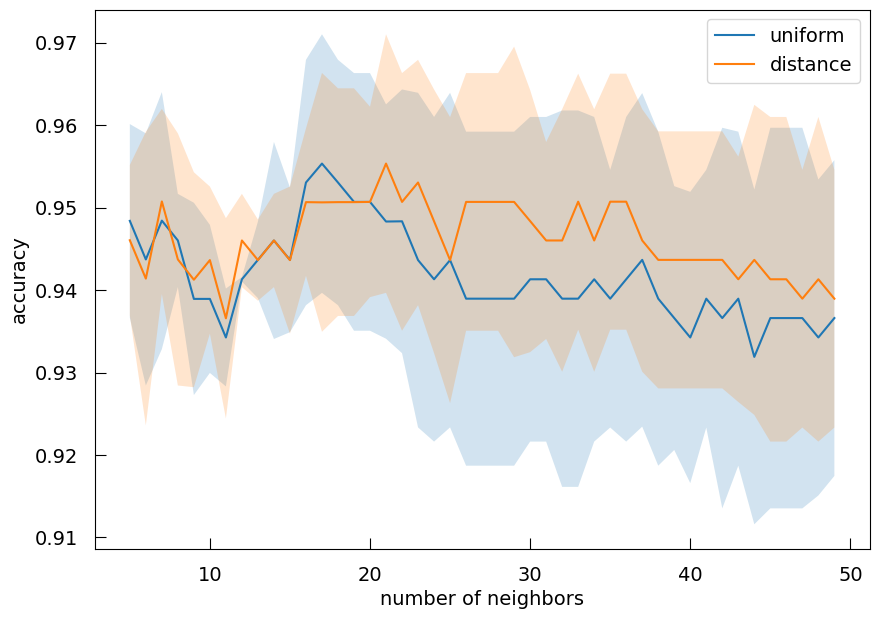

In [84]:
df_res = pd.DataFrame( grid_knn_acc.cv_results_ )
df_res.loc[:, [ 'param_model__n_neighbors', 'param_model__weights',  'mean_test_score', 'std_test_score' ]]


fig,ax = plt.subplots(1,1,figsize=(10,7))
for W in ['uniform','distance']:
    m = df_res.param_model__weights==W
    ax.plot( df_res.loc[m , 'param_model__n_neighbors'] , df_res.loc[m , 'mean_test_score'] , 
               label = W )
    ax.fill_between( np.array( df_res.loc[m , 'param_model__n_neighbors'] , dtype = int ), 
                       np.array( df_res.loc[m , 'mean_test_score']  - df_res.loc[m , 'std_test_score'] ),
                       np.array( df_res.loc[m , 'mean_test_score']  + df_res.loc[m , 'std_test_score']) , 
                    alpha = 0.2 )
ax.set_xlabel('number of neighbors')
ax.set_ylabel('accuracy')           
ax.legend()    

Once we have found the best set of hyper-parameters using cross-validation, we can evalutae our final model on the test set.

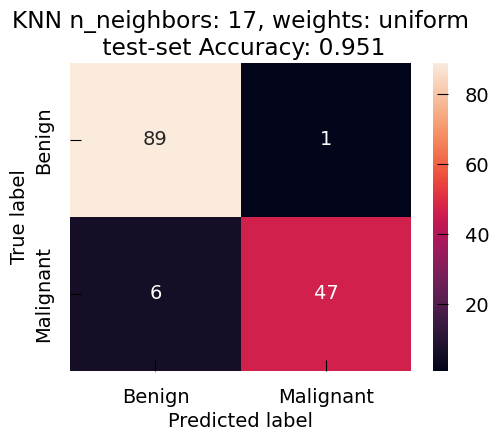

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix

# let's define a nice function to get a confusion matrix plot

def plotConfusionMatrix( true_labels, predicted_labels, label_list , title , ax = None):

    confusion_mc_c = confusion_matrix(true_labels, predicted_labels)
    df_cm_c = pd.DataFrame( confusion_mc_c , 
                           index = label_list,
                           columns=label_list)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5.5,4))
    sns.heatmap(df_cm_c, annot=True , ax = ax)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


# finally, evaluate your model on the test set
test_score = grid_knn_acc.score(X_cancer_test,y_cancer_test)

## predicting the labels on the test set    
y_pred_test_c=grid_knn_acc.predict(X_cancer_test)


plotTitle = 'KNN n_neighbors: {}, weights: {}\n test-set Accuracy: {:.3f}'.format(grid_knn_acc.best_params_['model__n_neighbors'],
                                                                        grid_knn_acc.best_params_['model__weights'],
                                                                         test_score )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)
    


**Congrats!!!! You just trained a classical machine learning model using best practice in term of scaling, hyperparameter choice, and data leakage.**

You just followed the routine that will be ours in this whole course.

![pres2](../images/Presentation2.png)

Now you might want to save your beautiful model so you can use it latter on , with new unknown data. For that you will need to.

Retrain your model on the full training set using the `grid_knn_acc.best_params_` best hyperparameters found (NB: by default GridSearchCV does this already). 

Then **save your trained model using pickle**.


```python
import pickle
pickle.dump(model, open(filename, 'wb'))
```

**if you want to load it again**
```python
loaded_model = pickle.load(open(filename, 'rb'))
```

### Great we have a model but : **Was accuracy actually the metric we wanted to optimize on??**

Even though our **accuracy is pretty good we are still missing 4 cancers**. 

In this particular case labelling a malignant tumor as begnin can have huge consequences. **The types of error are not symetrical** (we could live with predicting false positive, the patient will have to do further testing, but false negative is bad) : missing malignant tumors is grave and we could try to tune our model so that it has a lower rate of false negatives even if it means that we will predict more malignant tumors when they are actually begnin and that our accuracy might decrease. 

We will see that when we want to care about different type of errors, we generally **use another metric for evaluation** in GridSearchCV. We'll see this in the next section.

But first, let's apply what we just saw to the penguin dataset:

[Back to ToC](#toc)

##  Exercise KNN <a class="anchor" id="MC-KN"></a>

Tune (ie. find the best hyperparameters and train) a KNN model for classifying penguin species.

In [86]:
X_penguin.head()

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  \
1                39.5               17.4                186.0         3800.0   
2                40.3               18.0                195.0         3250.0   
4                36.7               19.3                193.0         3450.0   
5                39.3               20.6                190.0         3650.0   
6                38.9               17.8                181.0         3625.0   

   Delta 15 N (o/oo)  Delta 13 C (o/oo)  Clutch Completion_Yes  Sex_MALE  
1            8.94956          -24.69454                      1         0  
2            8.36821          -25.33302                      1         0  
4            8.76651          -25.32426                      1         0  
5            8.66496          -25.29805                      1         1  
6            9.18718          -25.21799                      0         0

In [87]:
y_penguin.value_counts()

Adelie       139
Gentoo       118
Chinstrap     67
Name: Species, dtype: int64

In [88]:
# %load -r 1-7 solutions/solution_02_KNN.py
## splitting in train and test sets

In [89]:
# %load -r 7-26 solutions/solution_02_KNN.py
## defining a pipeline and exploring hyper-parameter space

In [90]:
# %load -r 27-34 solutions/solution_02_KNN.py
## report results

In [91]:
# %load -r 35- solutions/solution_02_KNN.py
## predicting the labels on the test set    

[Back to ToC](#toc)

# Logistic regression <a class="anchor" id="Logistic-regression"></a>

**The main hypothesis of logistic regression is that the log odds ratio of the probability that a point is part of a certain class follows a linear combination of the features describing this point.** This is equivalent to the assumption that the two classes are linearly separable and that the log odds ratio increases linearly with the distance from the separating line.

Let's say you only have two classes and so your target variable can only take two values $y_{i} \in\{1,0\}$. Let's define $p(\pmb{x})=P(y=1)$ the probability than your datapoint $\pmb{x}$ belongs to class 1. Let's also say that you have $M$ features to describe a point $\{\pmb{x}_{i}\}_{i=1,...,M}$. And that you have N points.

Then we make the hypothesis that:

$log{\frac{p}{1-p}}=w_{0}+\Sigma^{M}_{i=1}w_{i}x_{i}=w_{0}+\pmb{x}\cdot\pmb{w}$

which translates to

$p(\pmb{x}|y=1)=\frac{1}{1+e^{-(w_{0}+\pmb{x}\cdot\pmb{w})}}$  


![logreg](../images/lr.png)

**So the probability that your datapoint is in class 1 is the logistic function (sigmoid) applied to the linear combination of features.** The larger the weights $\pmb{w}$ the steeper the change between the two classes. The values of $\pmb{w}$ are stored by the 'coeff_' attribute of the [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class. $w_{0}$ is stored in 'intercept_'. The function 'decision_function($\pmb{x}$)' returns $w_{0}+\pmb{x}\cdot\pmb{w}$ and 'predict_proba($\pmb{x}$)' returns $p(\pmb{x}|y=1)$ and $p(\pmb{x}|y=0)$

Unlike KNN the logistic regression model provides valuable information on the importance of features for the classification. The bigger the absolute value of the weight $w_{i}$ associated with a feature, the more important this feature is to discriminate between your classes (supposed that features are normalized and mapped onto a similar scale).

Fitting a logistic regression model corresponds to optimizing the loss function

$\pmb{w},w_{0}=argmin_{\pmb{w},w_{0}}\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})$
<br><br>
$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})=\Sigma^{N}_{i=1}y_{i}\log(p(\pmb{x}_i|y=1))+(1-y_{i})\log(p(\pmb{x}_i|y=0))$

So, now the way we get the w is from fitting our distribution of probability that a point is in class 1. If the number of features is high and there is a significant amount of non-informative features, the fitting procedure can become unstable. What happens is that some weights of non-informative features may become very large in order to minimize the loss function on the training data, which may lead to reduced performance on the test data (overfitting).

In order to avoid this situation we can add a penalty to the loss function that avoids that weights $w_{i}$ become too large. In ML three such penalties are commonly used:

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}|w_{i}|$ , l1 regularization (Lasso) C being the inverse of the weight that you put on that regularization 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}w_{i}^{2}$ , l2 regularization (Ridge) 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}(\alpha|w_{i}|+(1-\alpha)w_{i}^{2})$ , elasticnet

For a deeper understanding of those notions :

https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a


The l1 (lasso) regularization produces many zero weights. It is useful for the case where you suspect that only a few features are informative. l2 (ridge) regularization leads to many features with small, but non-zero weights. The l1 regularization may have more bias, and the l2 more variance. The elasticnet interpolates between these two situations at the cost of having and additional parameter $\alpha$.



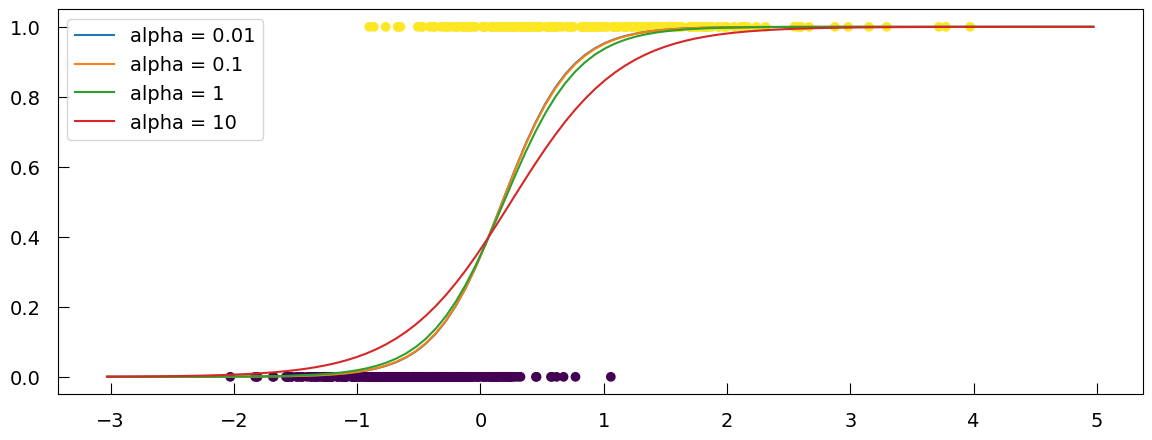

In [92]:
x = np.array( df_cancer.loc[:,['mean radius']] )
x_norm = StandardScaler().fit_transform(x)
y = df_cancer['malignant']

fig,ax = plt.subplots(1,1, figsize = (14,5) )
ax.scatter( x_norm , y , c = y )
for alpha in [0.01,0.1,1,10]:
    
    # this implementation does not take alpha but rather C = 1/alpha
    C = 1/alpha
    lr = LogisticRegression( penalty = 'l2' , C = C  , solver='liblinear')
    lr.fit(x_norm , y)
    
    proba = lr.predict_proba(np.linspace(x_norm.min()-1,x_norm.max()+1,100).reshape(-1, 1))
    ax.plot( np.linspace(x_norm.min()-1,x_norm.max()+1,100) , proba[:,1] , label = 'alpha = {}'.format(alpha) )
ax.legend()

[Back to ToC](#toc)

## logistic regression on the breast cancer dataset  <a class="anchor" id="LR-hyper"></a>

In [93]:

## logistic regression without regularization
lr = LogisticRegression(penalty='none')
lr.fit(X_cancer_train_scaled, y_cancer_train)

y_pred_test_scaled=lr.predict(X_cancer_test_scaled)

y_pred_train_scaled=lr.predict(X_cancer_train_scaled)

print('none: Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(lr.score(X_cancer_train_scaled,y_cancer_train),\
                                                           lr.score(X_cancer_test_scaled,y_cancer_test)))

none: Acc= 0.948 on scaled train, Acc= 0.937 on scaled test


We are likely to be overfitting.

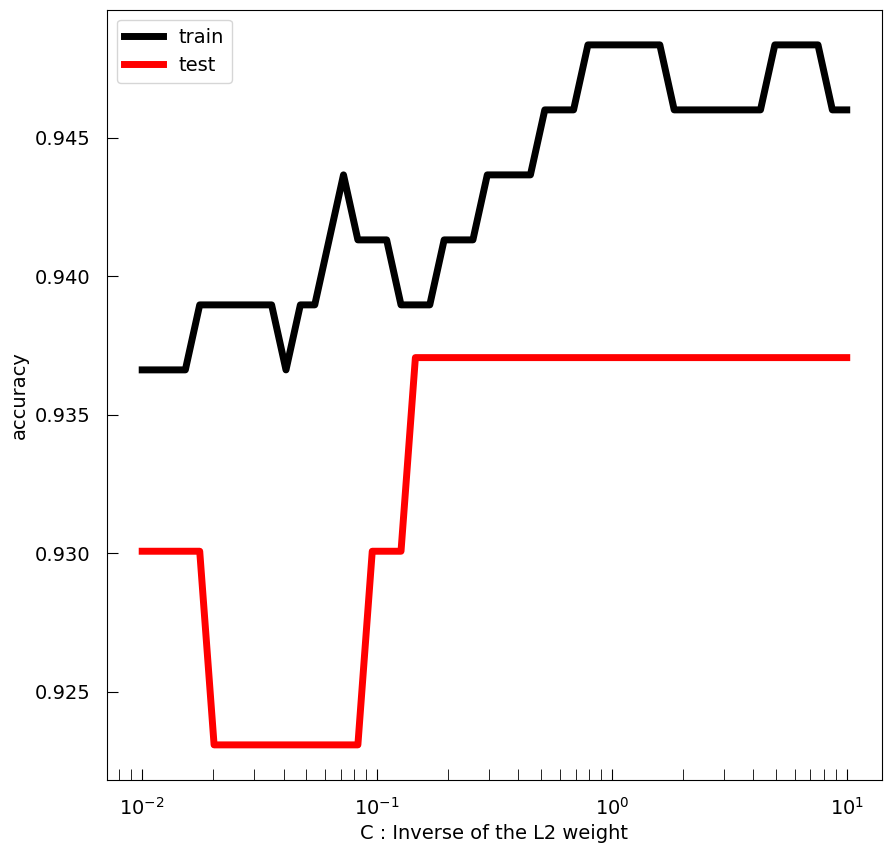

In [94]:
## let's test different strength of L2 regularization
## we use np.logspace to generate 50 points between 10**-2 and 10**1
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l2',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L2 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In this plot, the **left part corresponds to more regularization** 


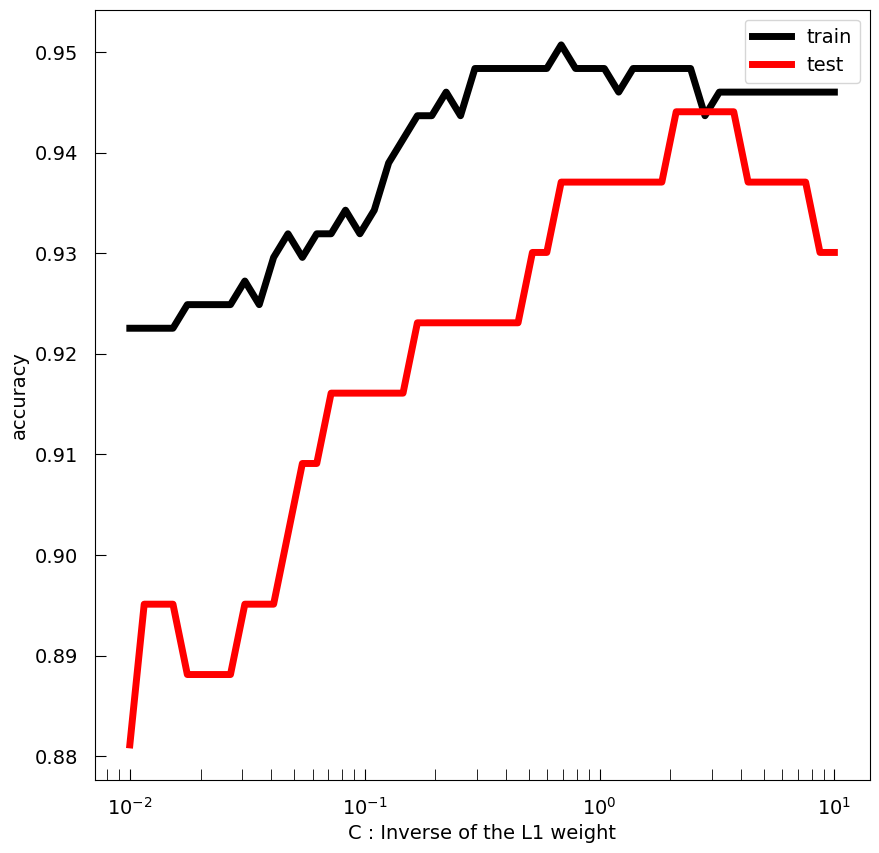

In [95]:
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l1',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L1 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

Whatever the penalty norm is, we observe the same thing. **Train and test accuracy increase together with the inverse of the norm weight: starting from too much regularization we are not actually fitting our data at first.... At some point we see the overfitting rising: test accuracy drops while train accuracy flatten at a perfect 1. This makes sense: we add a penalty to avoid overfitting and going to the right side of the graph we reduce this counter measure. We can see here that there is indeed an optimal value, in between of those two extremes, for the strenght of our regularization.**

That penalty is tuned by the type of norm we are using but also by a scalar. Here we represent the scalar by its inverse... So the more we go on the right side of the plot the less we counter overfitting. But if we are too much on the left side of plot then the penalty is too big and it becomes difficult to fit our data! 

In [96]:
import warnings
from sklearn.exceptions import ConvergenceWarning

logi_r=LogisticRegression(penalty='elasticnet', max_iter=1000,
                          solver='saga',n_jobs=1) 
## only the saga solver supports elacticnet
# here there is a little trick : elacticnet is a mix or l1 and l2, determined by hyperparameter l1_ratio 
# we make this ratio takes values from 0 to 1 included, so this actually encompasses pure l1 and pure l2 normalisation

pipeline_lr=Pipeline([('scalar',StandardScaler()), 
                      ('model',logi_r)])

from sklearn.model_selection import GridSearchCV

grid_values = {'model__C': np.logspace(-2,1,20),
               'model__l1_ratio': [0] + list( np.logspace(-4,0,10) )}
# define the hyperparameters you want to test
# with the range over which you want it to be tested.


# Feed it to the GridSearchCV with the right
# score(here accuracy) over which the decision should be taken
grid_lr_acc = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='accuracy',
                           cv=5,
                           n_jobs=1)


## this cell throws a lot of warning, I remove them with the lines under
with warnings.catch_warnings():
    warnings.simplefilter('ignore',  category=ConvergenceWarning)
    grid_lr_acc.fit(X_cancer_train, y_cancer_train)

print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation dataset

Grid best parameter (max. accuracy):  {'model__C': 0.5455594781168517, 'model__l1_ratio': 1.0}
Grid best score (accuracy):  0.9460465116279071


In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix
# get the equivalent score on the test
test_score=grid_lr_acc.score(X_cancer_test,y_cancer_test) 
print('Grid best parameter (max. accuracy) model on test: ', test_score)


y_pred_test_c=grid_lr_acc.predict(X_cancer_test)

cm = confusion_matrix(y_cancer_test, y_pred_test_c)

cdf = pd.DataFrame(cm,columns=['benign','malignant'],index=['benign','malignant'])

print(cdf)


Grid best parameter (max. accuracy) model on test:  0.9300699300699301
           benign  malignant
benign         89          1
malignant       9         44


Let's check how the model actually discriminates the two classes with the code below. Or said differently : what can we learn from our model a part from pure classification.

In [99]:
from operator import itemgetter
lr = grid_lr_acc.best_estimator_[1]
w=lr.coef_[0]#get the weights

featureW = pd.DataFrame( {'feature':df_cancer.columns[:-1],'weight':w} )

featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )


Features sorted per importance:
                  feature    weight
7     mean concave points  2.734045
0             mean radius  1.333488
3               mean area  1.307724
1            mean texture  1.064518
6          mean concavity  0.300960
4         mean smoothness  0.230112
8           mean symmetry  0.164348
9  mean fractal dimension -0.037786


<br>

[Back to the ToC](#toc)

<br>

## Imbalanced dataset <a class="anchor" id="imbalanced"></a> 

Let's use the same small example as before, but now instead of 300 sample of each class, imagine we only have 30 of class 1:

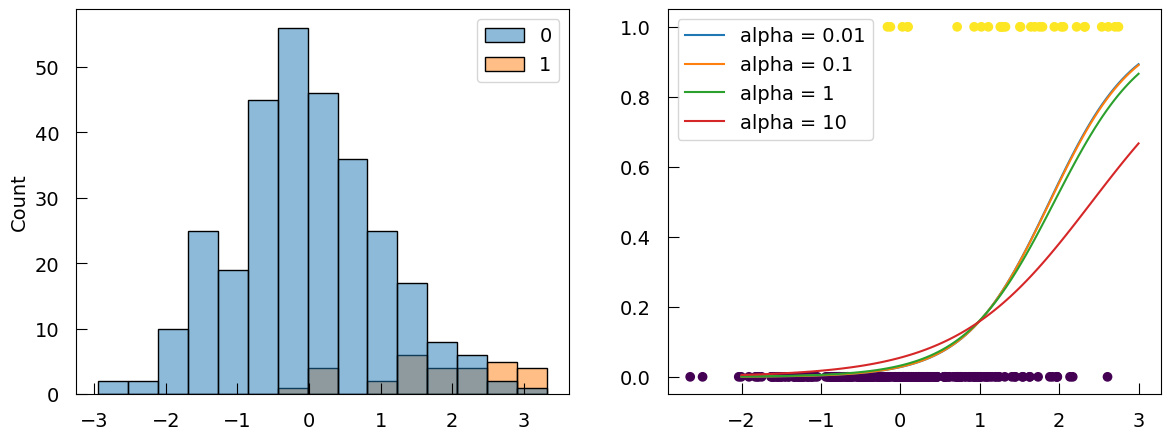

In [100]:
X1 = np.concatenate( [ np.random.randn(300) , np.random.randn(30)+2 ])
y = np.array( [0]*300 + [1]*30 )

# do not forget to scale the data
X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

fig,ax = plt.subplots(1,2, figsize = (14,5) )

sns.histplot( x=X1,hue = y , ax =ax [0])


ax[1].scatter( X1_norm , y , c = y )

for alpha in [0.01,0.1,1,10]:
    
    # this implementation does not take alpham but rather C = 1/alpha
    C = 1/alpha
    lr = LogisticRegression( penalty = 'l2' , C = C )
    lr.fit(X1_norm , y)
    
    proba = lr.predict_proba(np.linspace(-2,3,100).reshape(-1, 1))
    ax[1].plot( np.linspace(-2,3,100) , proba[:,1] , label = 'alpha = {}'.format(alpha) )
ax[1].legend()

You can see that now the point where the probability curves for different alpha converge is not 0.5 anymore...

Also, the probability says fairly low even at the right end of the plot.

In [101]:
y_predicted = lr.predict(X1_norm)
print( f"Accuracy with a threshold of 0.5 : {accuracy_score(y,y_predicted):.2f}"  )
pd.crosstab( y , y_predicted )

Accuracy with a threshold of 0.5 : 0.92


col_0    0  1
row_0        
0      299  1
1       26  4

So, most of the class 1 samples are miss-classified (22/30), but we still get a very high accuracy...

That is because, by contruction, both the **logistic regression and accuracy score do not differentiate False Positive and False Negative**.

And the problem gets worse the more imbalance there is :

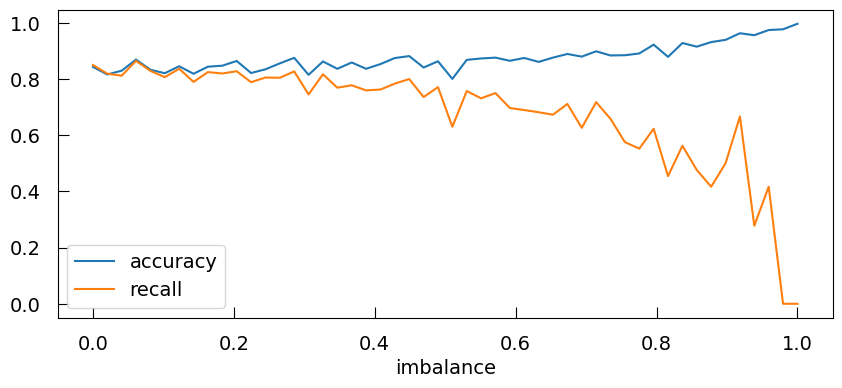

In [102]:
from sklearn.metrics import recall_score

## RECALL = TP / (TP + FN)

recall_list = []
acc_list = []

imbalance_list = np.linspace(0,1,50)

alpha = 1
for imbalance in imbalance_list:

    n0 = 300
    n1 = int( n0 * (1 - imbalance) )
    if n1 == 0:
        n1 = 1
    
    X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
    y = np.array( [0]*n0 + [1]*n1 )

    X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))
    
    C = 1/alpha
    lr = LogisticRegression( penalty = 'l2' , C = C )
    lr.fit(X1_norm , y)
    
    y_predicted = lr.predict(X1_norm)
    
    recall_list.append( recall_score( y , y_predicted ) )
    acc_list.append( accuracy_score(y,y_predicted) )

        
fig,ax=plt.subplots(figsize = (10,4))
ax.plot( imbalance_list , acc_list , label='accuracy' )
ax.plot( imbalance_list , recall_list , label='recall' )
ax.set_xlabel("imbalance")
ax.legend()

So not only does the precision get worse, the **accuracy actually gets higher as there is more imbalance!**

So the problem here may be 2-fold:
 * imbalance in our dataset skews the **logistic regression** toward a particular outcome
 * **accuracy** is not able to differenciate between False Positive and False Negative, and so it is **blind to imbalance**

Consequently, the solutions will have to come both from the model, and from the metric we are using.


**For the logistic regression**:
 * we will re-weight sample according to their class frequency, so that they are more important during the fitting.
 * in sklearn : `LogisticRegression( ... , class_weight='balanced')`
 
<br> 

**For the metric**, there exists several metrics which are sensitive to imbalance problems. 
Here we will introduce some of the main ones:

- **[balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)**:

$$balanced\_accuracy = 0.5*( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} )$$

- **[average-precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)**: weighted mean of precisions achieved at each recall threshold


Precision : $\frac{\bf{TP}}{\bf{TP}+\bf{FP}}$

Recall : $\frac{\bf{TP}}{\bf{TP}+\bf{FN}}$



<img src="../images/precision_recall_curve.png" alt= "precision-recall curve" width="500px">

- **[ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)**: Area Under the Receiver Operating Characteristic Curve 

<img src="../images/ROC_curve.png" alt= "ROC" width="500px">



In [103]:
from sklearn.metrics import balanced_accuracy_score, recall_score , average_precision_score , roc_auc_score


def check_imbalance_effect( imbalance_list , class_weight = None):
    
    recall_list = []
    balanced_acc_list = []
    acc_list = []
    avg_prec_list = []
    roc_auc_list = []
    
    for imbalance in imbalance_list:

        n0 = 300
        n1 = int( n0 * (1 - imbalance) )
        if n1 == 0:
            n1 = 1

        X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
        y = np.array( [0]*n0 + [1]*n1 )

        X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

        # LR
        lr = LogisticRegression( penalty = 'l2' , C = 1 , class_weight=class_weight)
        lr.fit(X1_norm , y)

        y_predicted = lr.predict(X1_norm)

        recall_list.append( recall_score( y , y_predicted )  )
        acc_list.append( accuracy_score(y,y_predicted) )
        balanced_acc_list.append( balanced_accuracy_score(y,y_predicted) )
        avg_prec_list.append( average_precision_score(y,y_predicted) )
        roc_auc_list.append( roc_auc_score(y,y_predicted) )

    return {'recall':recall_list , 
            'accuracy':acc_list , 
            'balanced_accuracy':balanced_acc_list , 
            'average_precision':avg_prec_list ,
            'ROC_AUC':roc_auc_list}

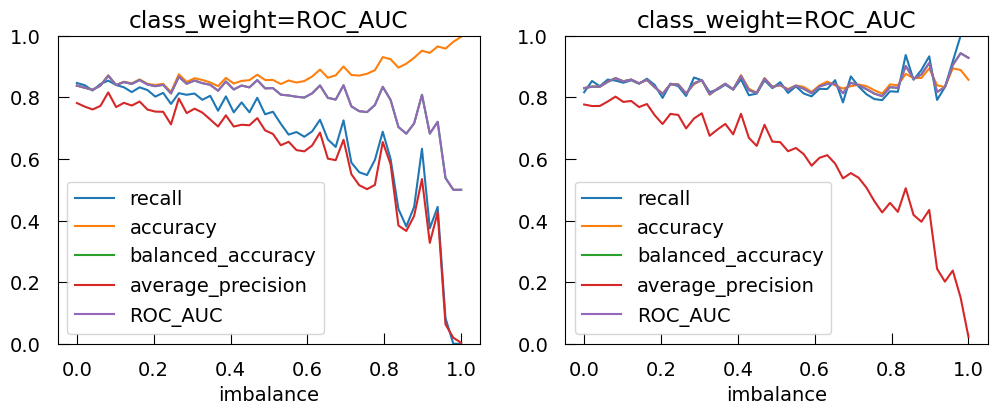

In [104]:
imbalance_list = np.linspace(0,1,50)

fig,ax=plt.subplots(1,2,figsize = (12,4))

for i,class_weight in enumerate([None,'balanced']):

    scores = check_imbalance_effect( imbalance_list , class_weight = class_weight)

    for scoreName in scores:
        ax[i].plot( imbalance_list , scores[scoreName] , 
                   label=scoreName )
    ax[i].set_xlabel("imbalance")
    ax[i].set_ylim(0,1)
    ax[i].set_title('class_weight={}'.format(scoreName,class_weight))
    ax[i].legend()


So, aside from accuracy, the metrics are able to detect an imbalance problem.

Setting `class_weight='balanced'` in our logistic regression fixes the imbalance at the level of the model,
which is reflected in several metrics, except the **average-precision**.

Let's look at that:

imbalance=0.1 recall 0.87	precision 0.84
imbalance=0.5 recall 0.84	precision 0.70
imbalance=0.8 recall 0.81	precision 0.46


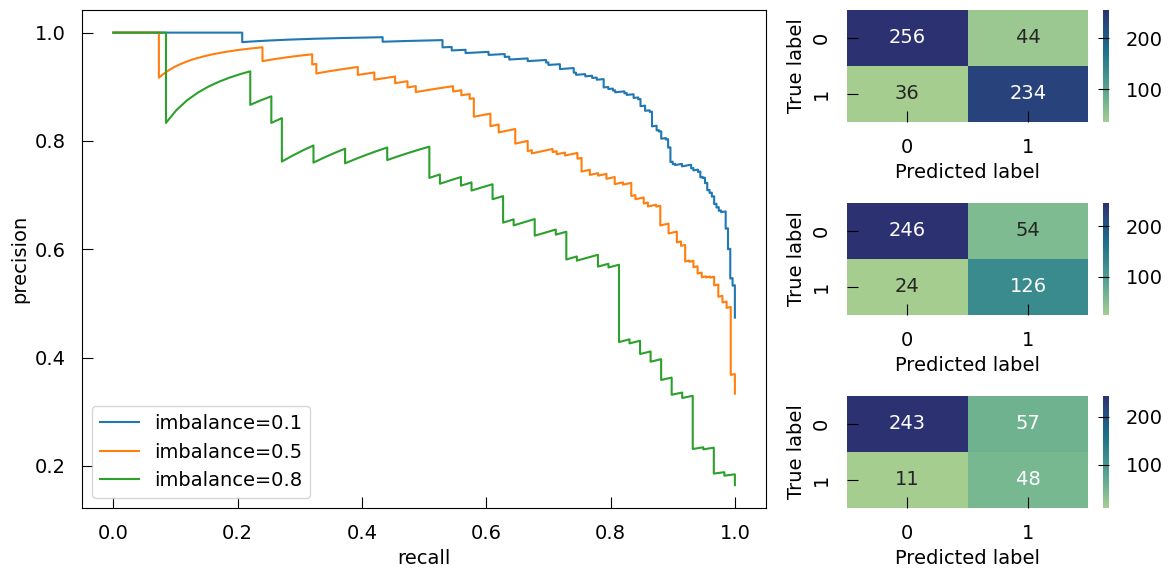

In [105]:
from sklearn.metrics import precision_score
from matplotlib import gridspec

fig=plt.figure(figsize = (12,6))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
axes = [ plt.subplot2grid((3, 3), (0, 2)) , plt.subplot2grid((3, 3), (1, 2)) , plt.subplot2grid((3, 3), (2, 2)) ]

for i,imbalance in enumerate( [0.1,0.5,0.8] ) : 

    ## setup 
    n0 , n1 = 300 , max( 1 , int( 300 * (1 - imbalance) ))
    
    X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
    y = np.array( [0]*n0 + [1]*n1 )
    X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

    # LR
    lr = LogisticRegression( penalty = 'l2' , C = 1 , class_weight='balanced')
    lr.fit(X1_norm , y)

    ## precision-recall curve
    y_scores = lr.decision_function(X1_norm)#decision_function gives you the proba for a point to be in
    prec, rec, thre = precision_recall_curve(y, y_scores)
    ax0.plot( rec, prec , label='imbalance={}'.format(imbalance) )    
    
    ## confusion matrix
    y_pred = lr.predict(X1_norm)
    confusion_m = confusion_matrix(y, y_pred)
    sns.heatmap(confusion_m, annot=True , ax = axes[i],fmt='.0f', cmap="crest")

    axes[i].set_ylabel('True label')
    axes[i].set_xlabel('Predicted label')
    
    print('imbalance={}'.format(imbalance) , 
          'recall {:.2f}\tprecision {:.2f}'.format(recall_score(y , y_pred) , precision_score(y , y_pred)) )
ax0.legend()
ax0.set_xlabel('recall')
ax0.set_ylabel('precision')

fig.tight_layout()

imbalance=0.1 recall 0.83	precision 0.79
imbalance=0.5 recall 0.86	precision 0.74
imbalance=0.8 recall 0.81	precision 0.49


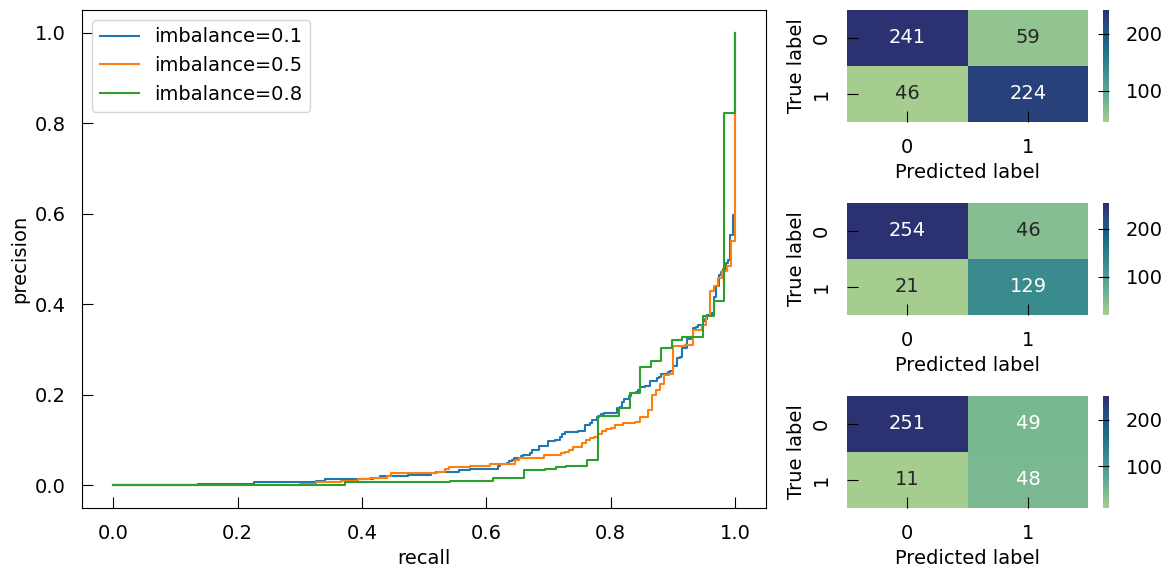

In [106]:
from sklearn.metrics import precision_score , roc_curve
from matplotlib import gridspec

fig=plt.figure(figsize = (12,6))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
axes = [ plt.subplot2grid((3, 3), (0, 2)) , plt.subplot2grid((3, 3), (1, 2)) , plt.subplot2grid((3, 3), (2, 2)) ]

for i,imbalance in enumerate( [0.1,0.5,0.8] ) : 

    ## setup 
    n0 , n1 = 300 , max( 1 , int( 300 * (1 - imbalance) ))
    
    X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
    y = np.array( [0]*n0 + [1]*n1 )
    X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

    # LR
    lr = LogisticRegression( penalty = 'l2' , C = 1 , class_weight='balanced')
    lr.fit(X1_norm , y)

    ## precision-recall curve
    y_scores = lr.decision_function(X1_norm)#decision_function gives you the proba for a point to be in
    prec, rec, thre = roc_curve(y, y_scores)
    ax0.plot( rec, prec , label='imbalance={}'.format(imbalance) )    
    
    ## confusion matrix
    y_pred = lr.predict(X1_norm)
    confusion_m = confusion_matrix(y, y_pred)
    sns.heatmap(confusion_m, annot=True , ax = axes[i],fmt='.0f', cmap="crest")

    axes[i].set_ylabel('True label')
    axes[i].set_xlabel('Predicted label')
    
    print('imbalance={}'.format(imbalance) , 
          'recall {:.2f}\tprecision {:.2f}'.format(recall_score(y , y_pred) , precision_score(y , y_pred)) )
ax0.legend()
ax0.set_xlabel('recall')
ax0.set_ylabel('precision')

fig.tight_layout()

So the **average-precision is still sensitive to imbalanced with balanced class weights** because precision **is a ratio across classes: TP and FP**.

In contrasts, the others only use in-labels metrics : TP and FN , TN and FP


In practice, how you handle imbalance should depend on the nature of your data and your problem.

Is the imbalance you see in your data representative of what it will on new data?

Do you care about the type of error you make, or you just want to make as little error as possible ? in the second case, simple accuracy might serve you better

Do you have pre-defined costs associated to different type of errors (eg. [DALY](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/158) of having un-needed surgery vs. DALY of not having needed surgery) ? In that case you may want to use these instead of class frequencies in the balancing and scoring.

---


Let's see concrete example with the immunology data from before:

In [107]:
# load immunology data of notebook 1
df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],-1)
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = 0
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = 1

df_im.loc[response==1,'Mutant peptide'] = df_im.loc[response==1,'Mutant peptide']+"*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]]

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im = X_im.rename(columns = d, inplace = False) # rename the columns
# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im['RNA_expr'] = np.log10(X_im['RNA_expr'])
X_im['WT_affin'] = np.log10(X_im['WT_affin'])
X_im['MUT_affin'] = np.log10(X_im['MUT_affin'])

# select the numerical features

X_im = X_im.set_index(df_im['Mutant peptide'], inplace=False)

X_im = X_im[response>=0]
y_im = response[response>=0]


In [108]:
sc = StandardScaler()
X_im_sc = sc.fit_transform(X_im)
lr_im = LogisticRegression('l2',C=10)
lr_im.fit(X_im_sc, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im_sc)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["true negative","true positive"])

print( 'accuracy {:.3f}'.format(accuracy_score(y_im,y_pred)))
print("No class weights")
print(cdf)
print("error on the negative category : {:.3f}".format( cm[0,1]/(cm[0,1]+cm[0,0]) ))
print("error on the positive category : {:.3f}".format( cm[1,0]/(cm[1,1]+cm[1,0]) ))

accuracy 0.839
No class weights
               negative  positive
true negative        43         2
true positive         7         4
error on the negative category : 0.044
error on the positive category : 0.636


You can see that the **classifier is very bad at predicting the positive cases** (7/11 wrongly classified!)

**Now, with the  `balanced` option**

In [109]:
from sklearn.metrics import balanced_accuracy_score
lr_im = LogisticRegression('l2',C=10,class_weight='balanced')
lr_im.fit(X_im_sc, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im_sc)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["true negative","true positive"])

print( 'accuracy {:.3f}'.format(accuracy_score(y_im,y_pred)))
print( 'balanced accuracy {:.3f}'.format(balanced_accuracy_score(y_im,y_pred))) ## the balanced accuracy score also re-weight error by category frequency
print("Balanced class weights")
print(cdf)

print("error on the negative category : {:.3f}".format( cm[0,1]/(cm[0,1]+cm[0,0]) ))
print("error on the positive category : {:.3f}".format( cm[1,0]/(cm[1,1]+cm[1,0]) ))

accuracy 0.821
balanced accuracy 0.820
Balanced class weights
               negative  positive
true negative        37         8
true positive         2         9
error on the negative category : 0.178
error on the positive category : 0.182


Now you can see that the error level is similar for both category

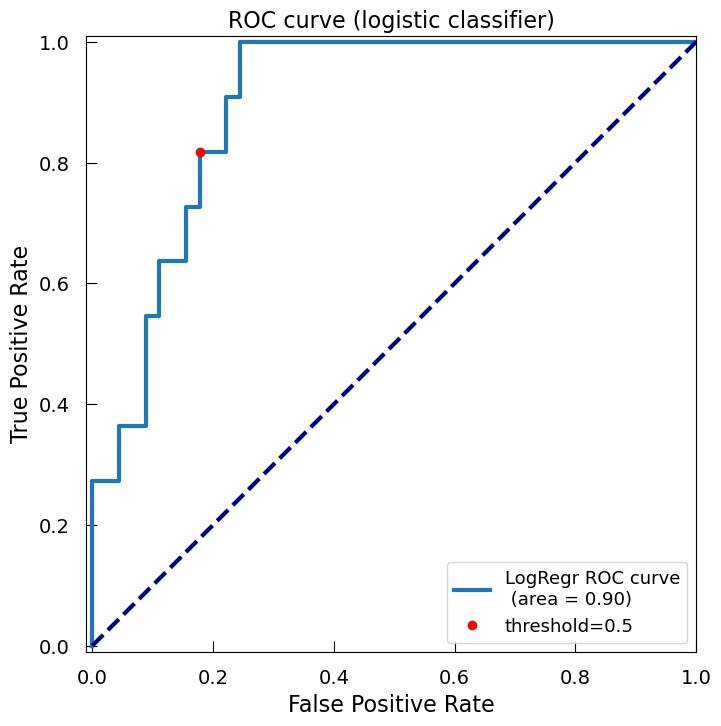

In [110]:
import scipy as sc
# this three lines here are how you get the area under the ROC curve score which is very important for evaluating your model
y_score_im = lr_im.decision_function(X_im_sc)#decision_function gives you the proba for a point to be in
# a class
fpr, tpr, thre = roc_curve(y_im, y_score_im)# this calculates the ROC curve
roc_auc = auc(fpr, tpr)#finally this calculates the area under the curve

## we search for the point which is the closest to the 0.5 probability level (from above)
## change the threshold_level to try out different levels
threshold_level = 0.5
proba=sc.special.expit(thre)
threshold = sum( proba > 0.5 )-1
       

plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr[threshold], tpr[threshold],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

From the plot above we see that putting our decision threshold to 0.5 to discriminate between cancer and non cancer lead to missing 2 or 3 % of the cancer. **So maybe a better threshold should be one where you have a TPR of one and a FPR as low as possible.**

**micro-exercise:** On the ROC curve can you find in which direction the threshold is getting bigger?


## micro-exercise: logistic-regression 

Now that you know about imbalance, train a logistic regression classifier on the cancer dataset with an appropriate metric

## Logistic regression in Multiclass <a class="anchor" id="LR-IRIS"></a>

LR is, originally, really about classifying 0 and 1, so binary.

Of course all of that can still be applied to a multi-class classification, with a little bit of adaptation.

There are many different ways of tackling the problem, which end up being combinations of these 3 elements :

* Either you treat the problem as **one class vs one class** (ie, you re-encode your data)
* Or you treat the problem as a **one class vs the rest** : you subdivide the problem into as many problem as there are classes
* You change your loss function to a multinomial one : softmax intead of a sigmoid.

In any case you need to decide how you are going to **agglomerate those different metrics** (different ROC curves for example):

 * **micro average** : pull all raw numbers together (eg. number of FP, TP), group them and then calculate your overall statistic (eg. TPR)
 * **macro average** : calculate each statistics separately and then do the average.

Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

> Spoiler: is has to do with overall separability and balance between the different class.

What strategy your logistic regression uses so you can plot the right curves, is a tricky question. For a first pass on your data always set the multiclasses method to be `ovr` (one vs rest) : understanding the hyperplanes relation to decision probability and the ROC curve is more intuitive that way, and I believe less sensitive to an imbalanced dataset.

All the ROC curve below are OnevsRest unless specified.

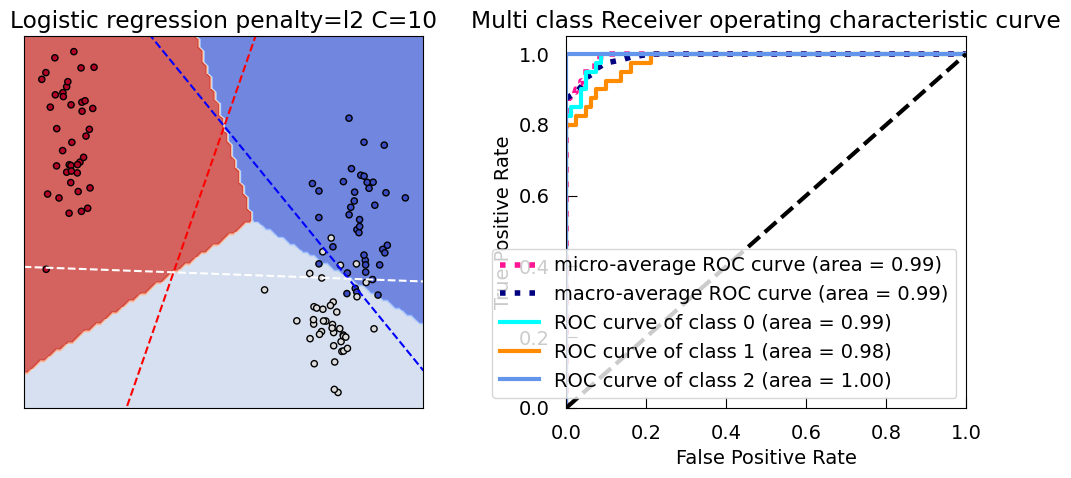

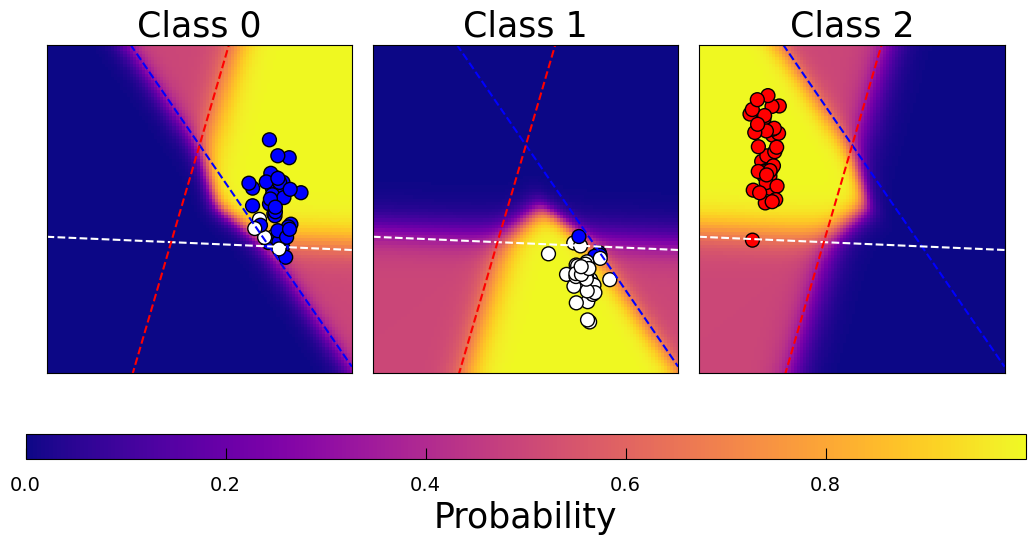

In [113]:
from utils import contour_lr
#one vs rest implementation
contour_lr('l2',X_3,y_3,10,'ovr')

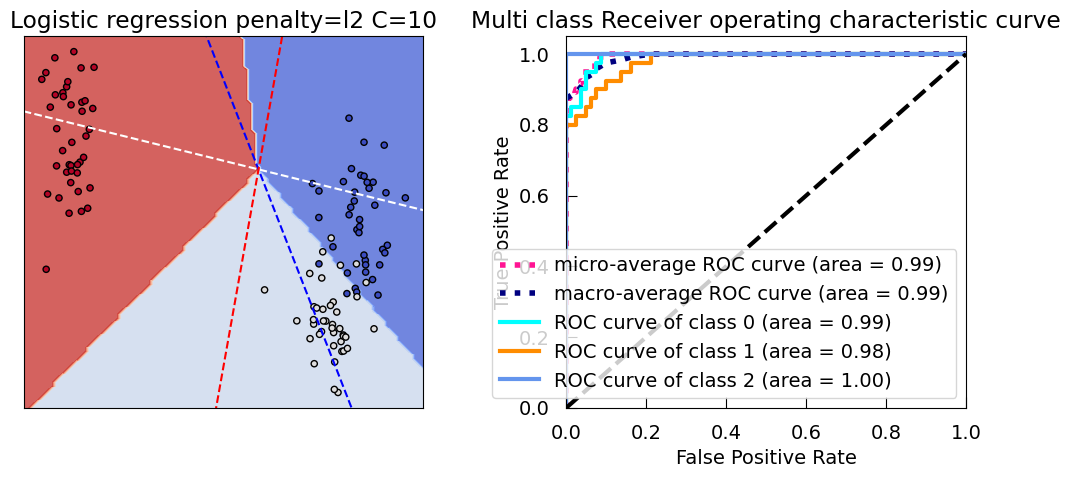

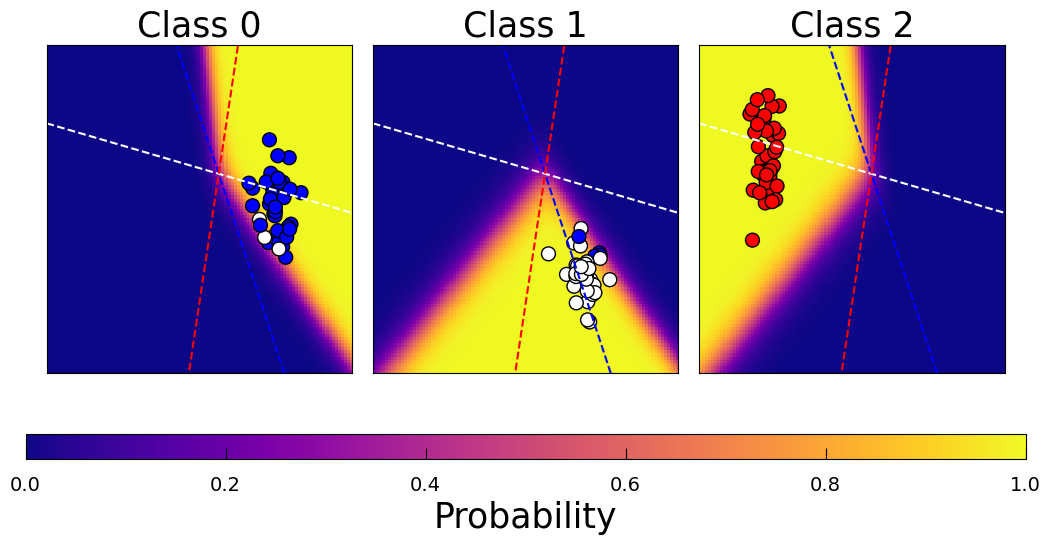

In [114]:
#Multinomial implementation** : the boundaries are less interpretable
contour_lr('l2',X_3,y_3,10,'multinomial')

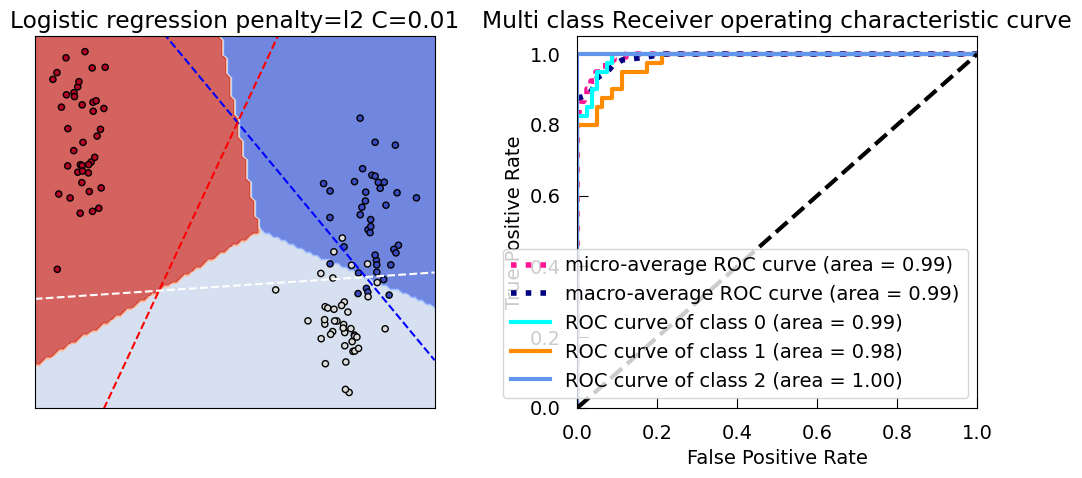

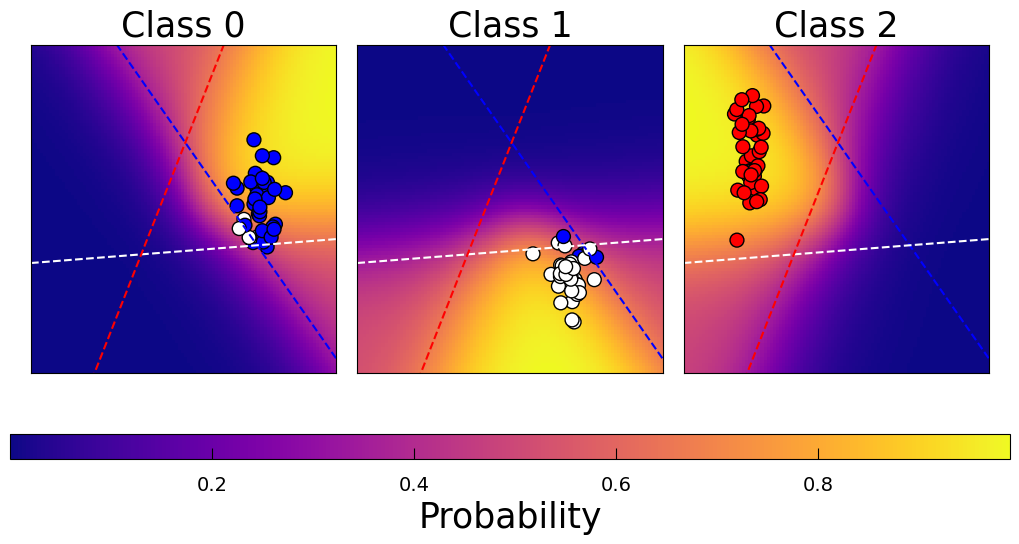

In [115]:
## more regularization
contour_lr('l2',X_3,y_3,10**-2,'ovr')

Let's apply this to the penguin dataset:

In [116]:
X_penguin_train, X_penguin_test, y_penguin_train, y_penguin_test = train_test_split(
                                                    X_penguin, y_penguin,
                                                    random_state=568132,stratify=y_penguin)

pipeline_lr=Pipeline([('scalar',StandardScaler()),
                     ('model',LogisticRegression(class_weight='balanced'))])

#hyper parameter space :
grid_values = {'model__C': np.logspace(-2,1,50),
               'model__penalty':['l1','l2'],
               'model__solver':['liblinear']}

# note the 'roc_auc_ovr' score!
grid_lr_auc_P = GridSearchCV(pipeline_lr, 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_lr_auc_P.fit(X_penguin_train, y_penguin_train)

print('Grid best parameter (max. roc_auc_ovr_weighted):')
print( '\t' + '\n\t'.join([str(x) for x in grid_lr_auc_P.best_params_.items()]))
print('Grid best score (roc_auc_ovr_weighted): ', grid_lr_auc_P.best_score_)


Grid best parameter (max. roc_auc_ovr_weighted):
	('model__C', 0.023299518105153717)
	('model__penalty', 'l2')
	('model__solver', 'liblinear')
Grid best score (roc_auc_ovr_weighted):  1.0


Grid best parameter (max. roc_auc_ovr_weighted) model on test:  1.0


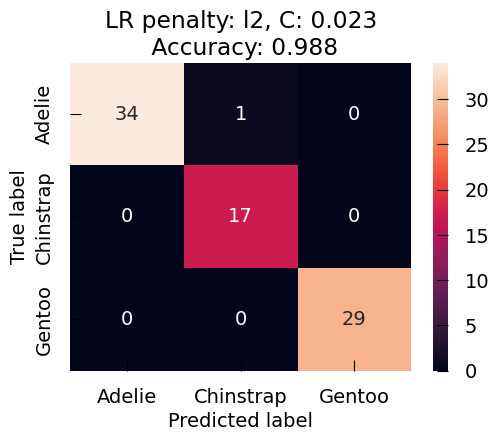

In [117]:
testScore=grid_lr_auc_P.score(X_penguin_test,y_penguin_test)
print('Grid best parameter (max. roc_auc_ovr_weighted) model on test: ', testScore)

## predicting the labels on the test set    
y_pred_test=grid_lr_auc_P.predict(X_penguin_test)

bestP = grid_lr_auc_P.best_params_['model__penalty']
bestC = grid_lr_auc_P.best_params_['model__C']
testAcc = accuracy_score(y_penguin_test,y_pred_test)
    
plotTitle = 'LR penalty: {}, C: {:.3f}\n Accuracy: {:.3f}'.format( bestP,
                                                               bestC,
                                                               testAcc)

plotConfusionMatrix( y_penguin_test, y_pred_test, 
                    ['Adelie','Chinstrap','Gentoo'] , plotTitle , ax = None)

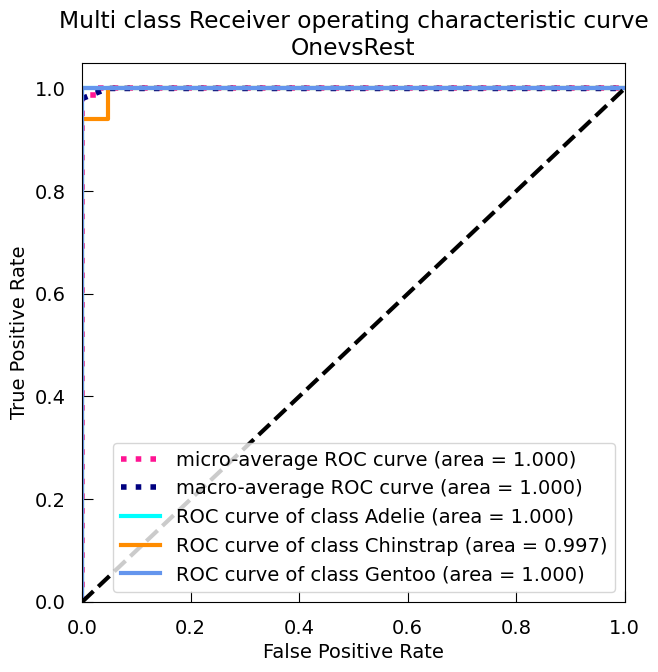

In [118]:
from utils import roc_multi_ovr

roc_multi_ovr(grid_lr_auc_P,3,
              X_penguin_train, 
              y_penguin_train,
              X_penguin_test, y_penguin_test)

In [119]:
## let's extract the model directly from the grid
lr_P = grid_lr_auc_P.best_estimator_['model']

# we get the weights of the fitted model, just for the class 0 : Adelie vs. rest
w=lr_P.coef_[0]

featureW = pd.DataFrame( {'feature': X_penguin.columns,
                        'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance for: Adelie prenguin vs. rest')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance for: Adelie prenguin vs. rest


feature    weight
0     Culmen Length (mm) -0.770998
2    Flipper Length (mm) -0.430684
1      Culmen Depth (mm)  0.413747
5      Delta 13 C (o/oo) -0.296637
3          Body Mass (g) -0.256330
7               Sex_MALE  0.179557
6  Clutch Completion_Yes  0.045069
4      Delta 15 N (o/oo)  0.023763

# Support Vector Machine (SVM) <a class="anchor" id="SVM"></a>

"The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about probability distribution or anything else. It is very geometrical.**

So what's a good threshold? Again it is going to depend on the metric you are interested in. But at least a good threshold should be linked to this biais variance trade off in the sens that it should offer flexibility to your model.

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.**

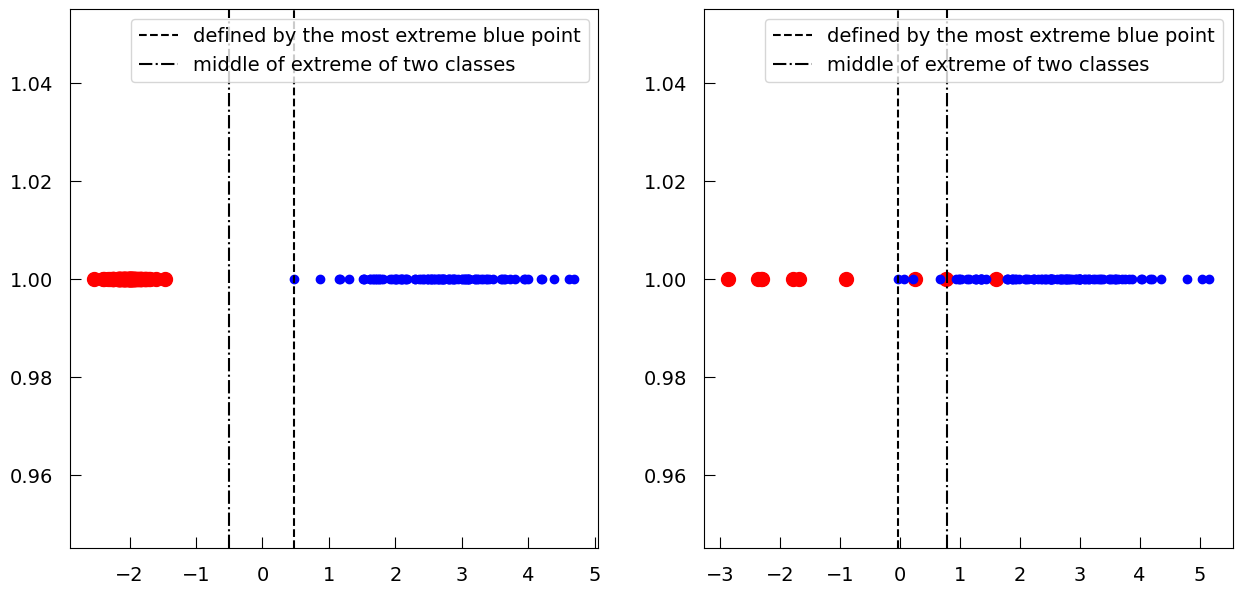

In [120]:
np.random.seed(10815657)
fig,ax = plt.subplots(1,2,figsize=(15,7))

# case 1 
norm1=0.2*np.random.randn(100)-2
norm2=0.8*np.random.randn(100)+2.5

# case 2
cauch=0.8*np.random.standard_cauchy(10)-2
norm=1*np.random.randn(100)+2.5

for i,Ds in enumerate( [ (norm1,norm2) , (cauch,norm) ] ):

    ax[i].plot(Ds[0],[1]*len(Ds[0]),'ro',markersize=10)
    ax[i].plot(Ds[1],[1]*len(Ds[1]),'bo')

    min2 = min( Ds[1] )
    max1 = max( Ds[0] )
    
    ax[i].axvline( min2 , color='k', linestyle='--', label='defined by the most extreme blue point')
    ax[i].axvline( (min2 +max1)/2,color='k',linestyle='-.',label='middle of extreme of two classes')
    ax[i].legend(loc='best')


So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification. We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have \"chosen\" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differentiating classes.**


![svm_margin](../images/SVM_margin.png)

Image source : image by wikipedia user Larhmam, distributed under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/deed.en).


So you want to maximize the margin separating the two classes. This margin is $\frac{2}{||\pmb{w}||}$. So you want to minimize $||\pmb{w}||$. The SVM loss function we want to minimize with respect to $\pmb{w}$ and $b$ is:

$C\cdot\Sigma^{N}_{i=1}\zeta_i + \frac{1}{2}||\pmb{w}||^{2}$ subject to $\zeta_i \ge 0$ and $y_{i}(w^{T}x_{i}-b) \ge 1-\zeta_i$, where $\zeta_i = \Sigma^{N}_{i=1}max(0,1-y_{i}(\pmb{w}\cdot\pmb{x}_i-b))$
 * $y_i$ is $-1$ or $1$ depending on the class of the point $i$
 * the class of point $\pmb{x}$ is determined by the SVM using the sign of $(\pmb{w}\cdot\pmb{x}-b)$ (ie, on which side of the $(\pmb{w}\cdot\pmb{x}-b)$ hyperplane we are).



Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then
* most of the time $y_{k}(w^{T}x_{k}-b) \geq 1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)=0$ (that's good for minimizing our loss function), 
* and a few times $y_{k}(w^{T}x_{k}-b) \leq -1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b) \geq 2$ (which is polluting our minimization of the loss function).



You can see that there is a [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is just the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerful for classification but going non-linear by using a kernel trick prevents you from interpreting how your features are massaged to create this classifier... So, if you want interpretability and do science rather than engineering : keep it linear.**


![3d_svm](../images/3d_svm.png)



### Toy data : linear kernel <a class="anchor" id="SVM-linear"></a>

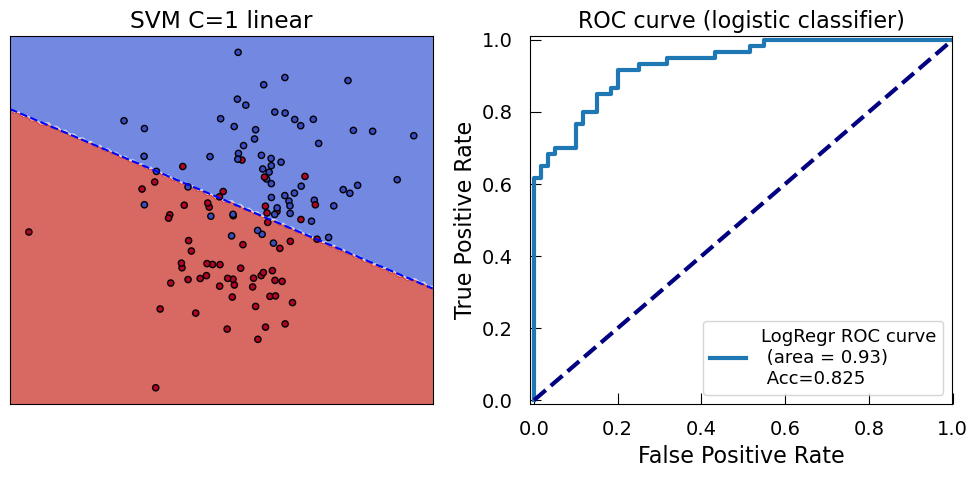

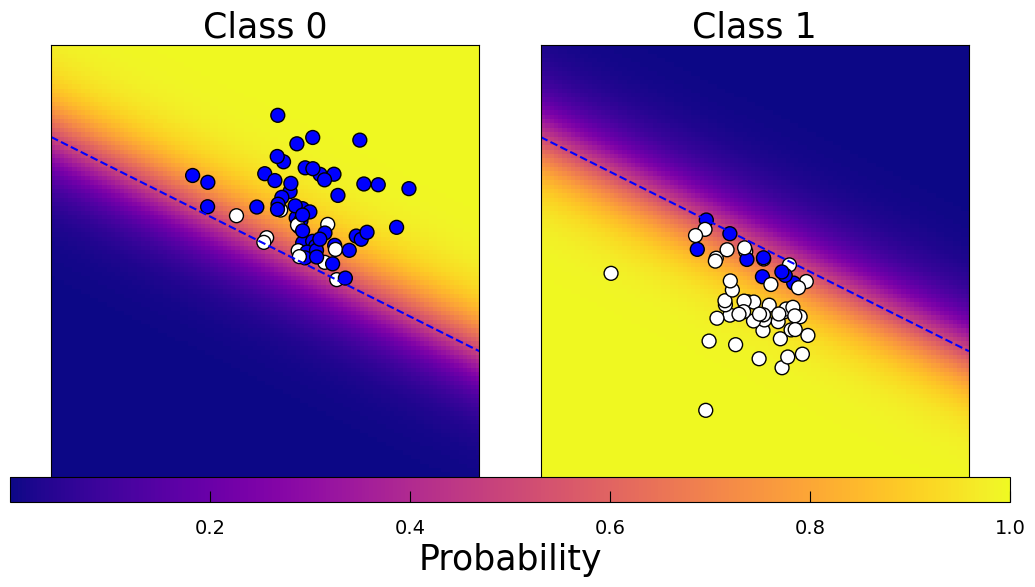

In [121]:
from utils import contour_SVM
from sklearn.datasets import make_blobs
X_toy_2, y_toy_2 = make_blobs(n_samples=120, centers=2,cluster_std=3, random_state=6)

#2 classes
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
contour_SVM(X_toy_2,y_toy_2,c=1,ker='linear')

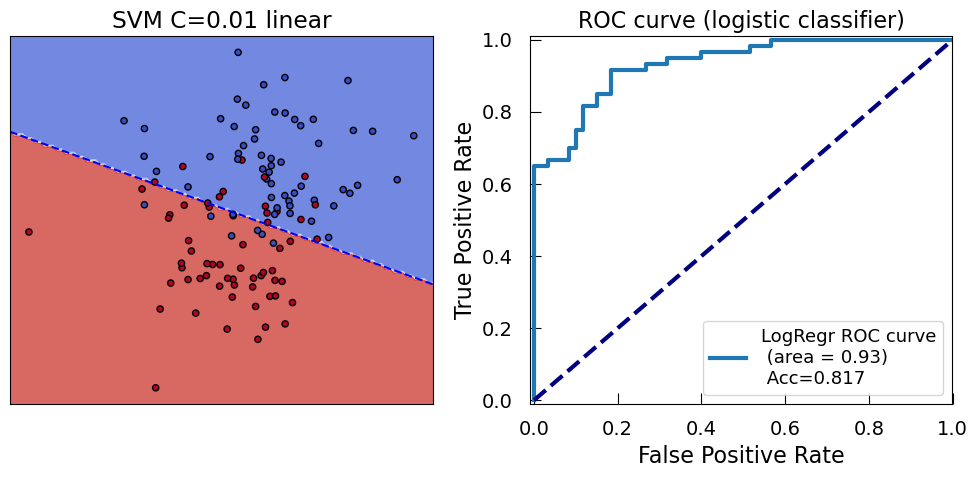

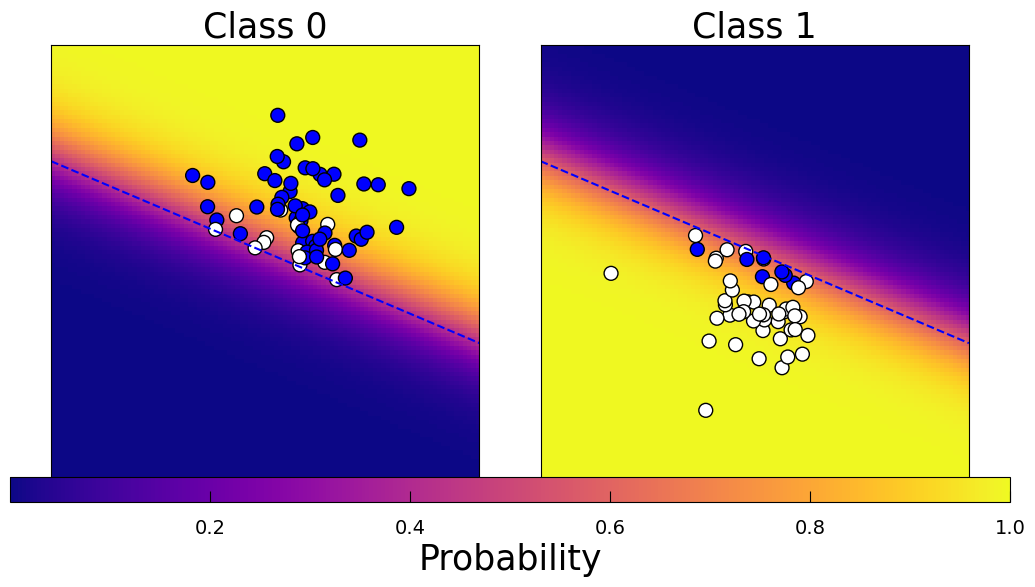

In [122]:
#2 classes
contour_SVM(X_toy_2,y_toy_2,c=0.01,ker='linear')

Reducing C to 0.01 reduces the cost of misclassification and makes the margin larger.

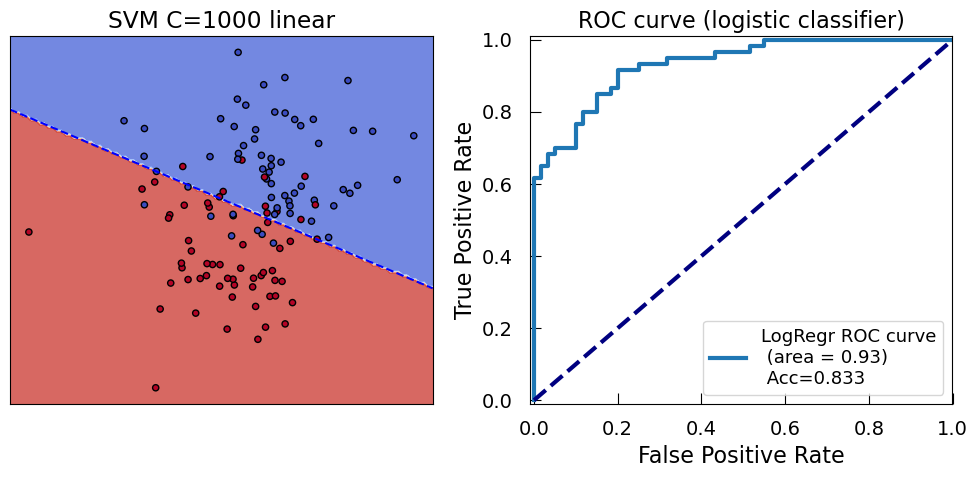

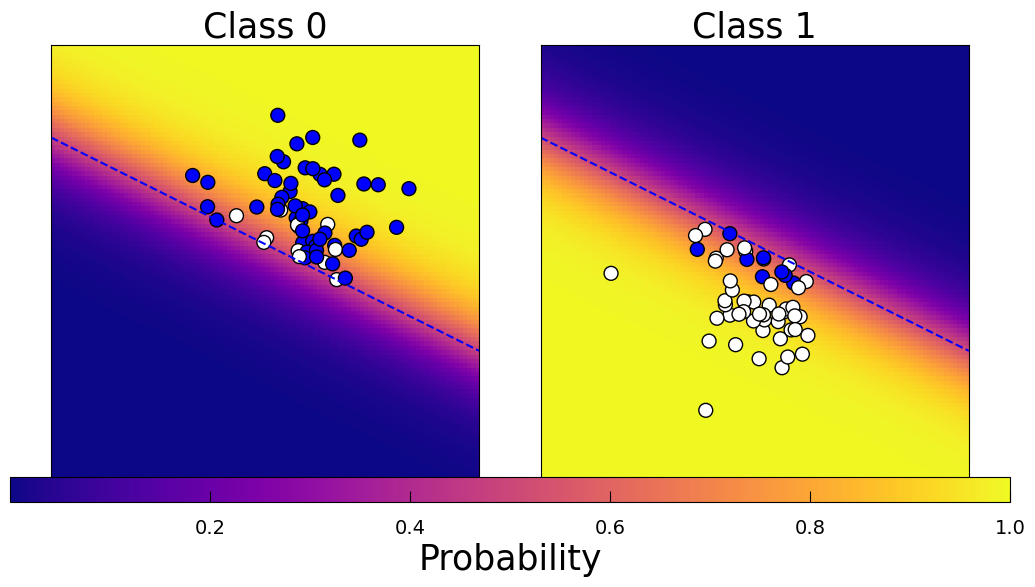

In [123]:
#let's put very little regularization
contour_SVM(X_toy_2,y_toy_2,c=1000,ker='linear')

The inverse is true. Increasing C does not make a big difference to C=1.

### Toy data non linear kernel <a class="anchor" id="SVM-nonlinear"></a>

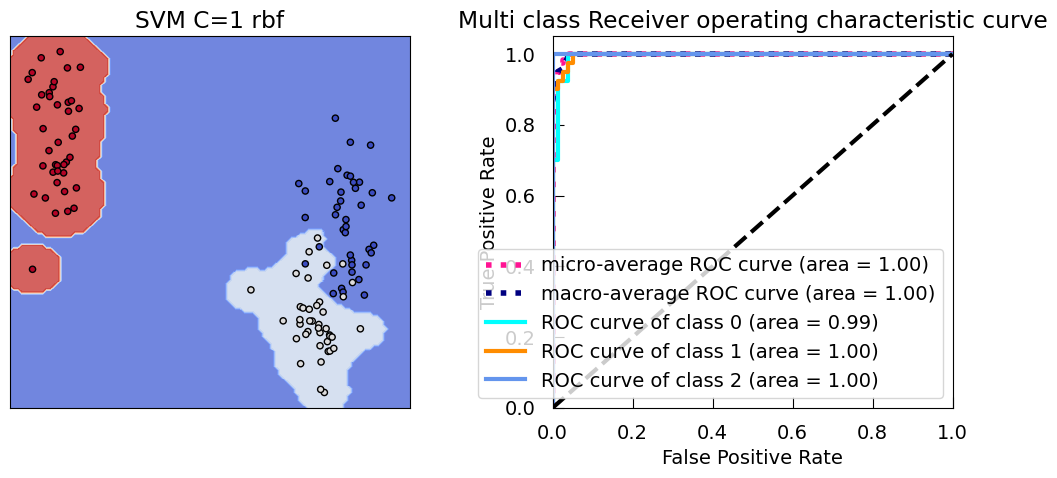

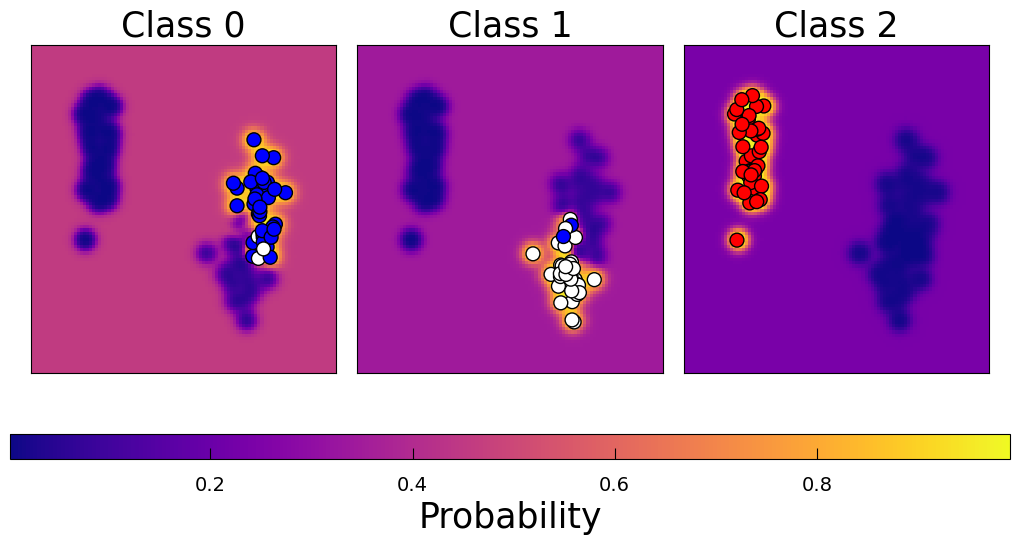

In [124]:
#let's change the scalar product and the notion of distance by using a rbf kernel
#Also we did'nt put much of regularization
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=1)

In the above example we changed the kernel from linear to Gaussian radial basis. See how the classification boundaries follow local class density levels?

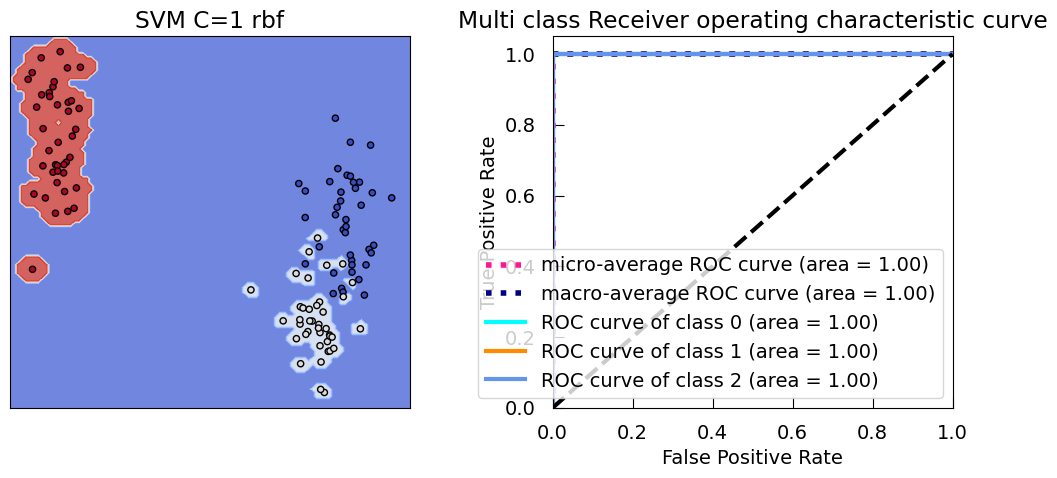

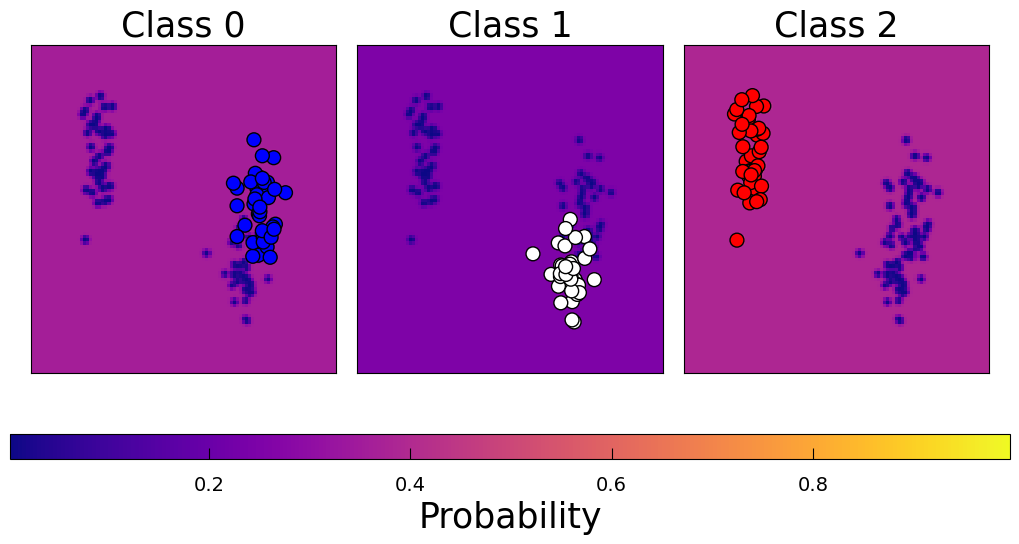

In [125]:
#even less regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=10)

In the above example we greatly reduce the standard deviation on the gaussian model (we increased $\gamma$). See how now the boundaries are really concentrated around each point? 

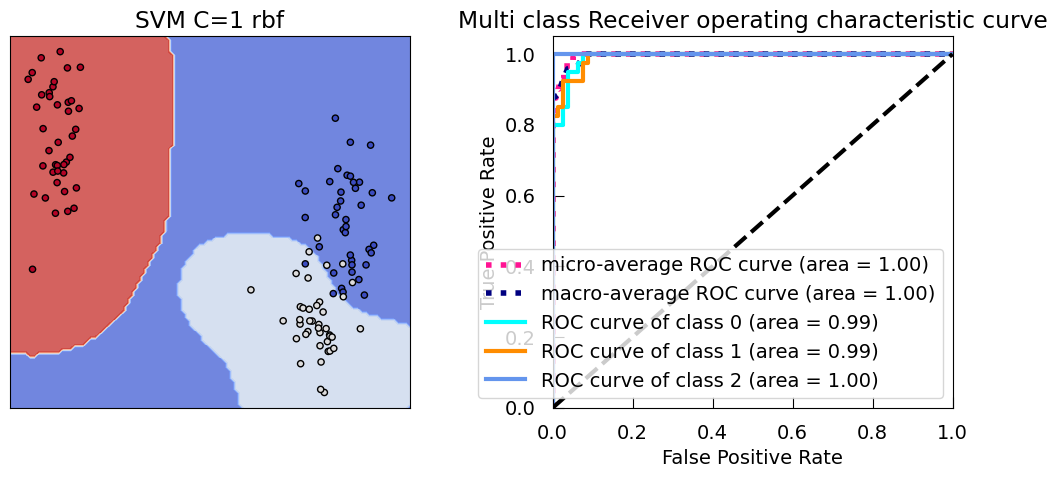

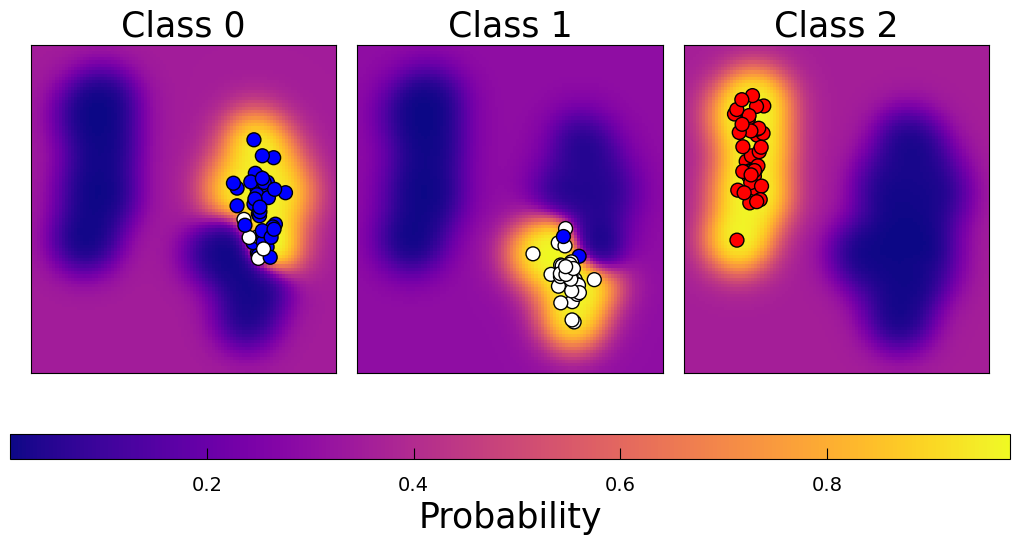

In [126]:
#more regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=0.1)

Inversely by expanding the variance in the gaussian we end up with larger chunks.

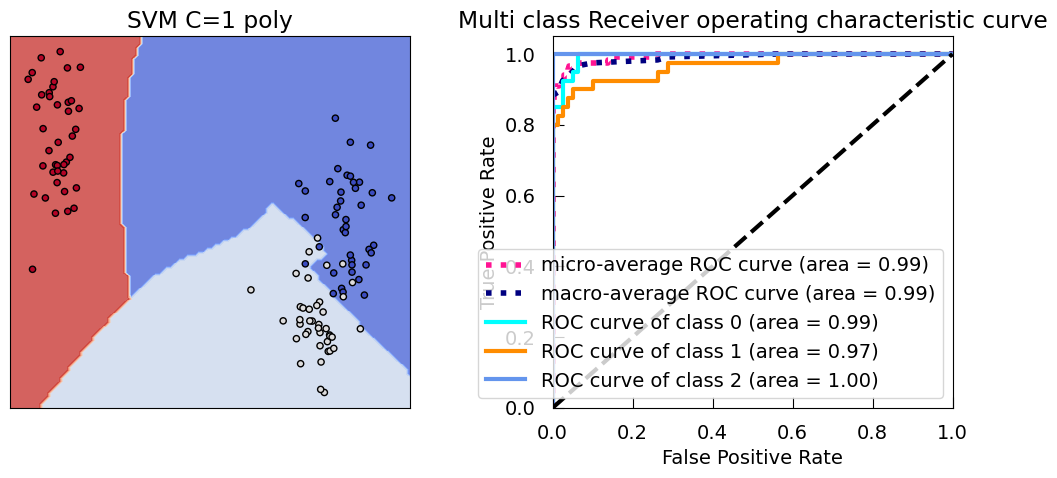

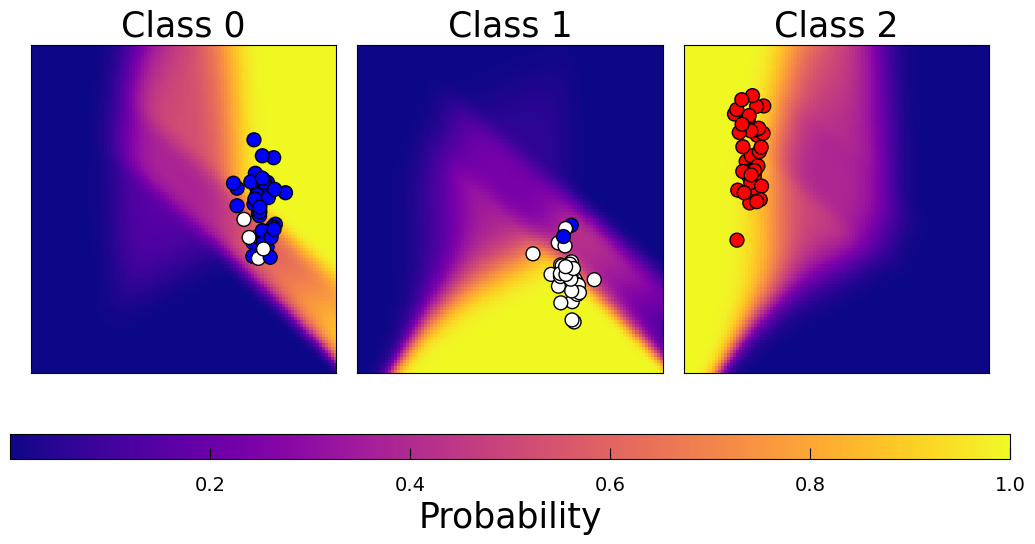

In [127]:
#little regularization but a polynomial kernel of degree 3 this time
contour_SVM(X_3,y_3,c=1,ker='poly',deg=3)

Finally, above we tried a degree 3 polynomial kernel?

### Cancer dataset <a class="anchor" id="SVM-hyperparameters"></a>

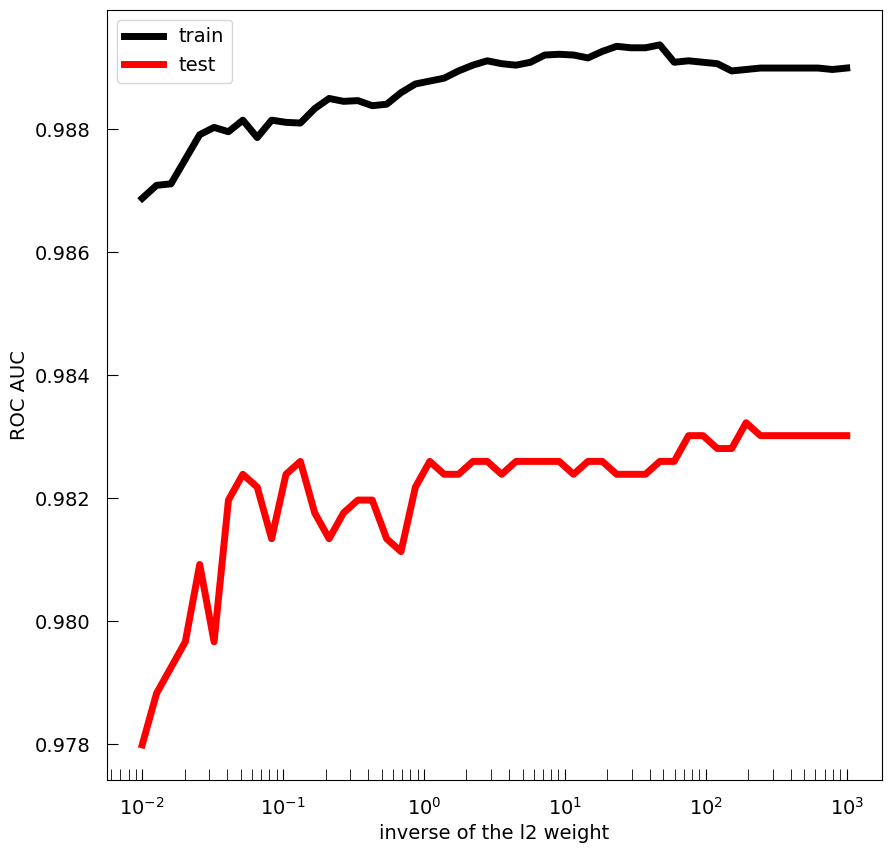

In [128]:
from sklearn.metrics import roc_auc_score
C_range=np.logspace(-2,3,50)


scores_test=[]
scores_train=[]

for k in C_range: 
    SVM_r = svm.SVC(C=k, kernel='linear', 
                    class_weight='balanced', probability=True)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)

    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)

plt.figure(figsize=(10,10))
plt.xlabel('inverse of the l2 weight')
plt.ylabel('ROC AUC')
plt.plot(C_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(C_range, scores_test,'r-',linewidth=5,label='test')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

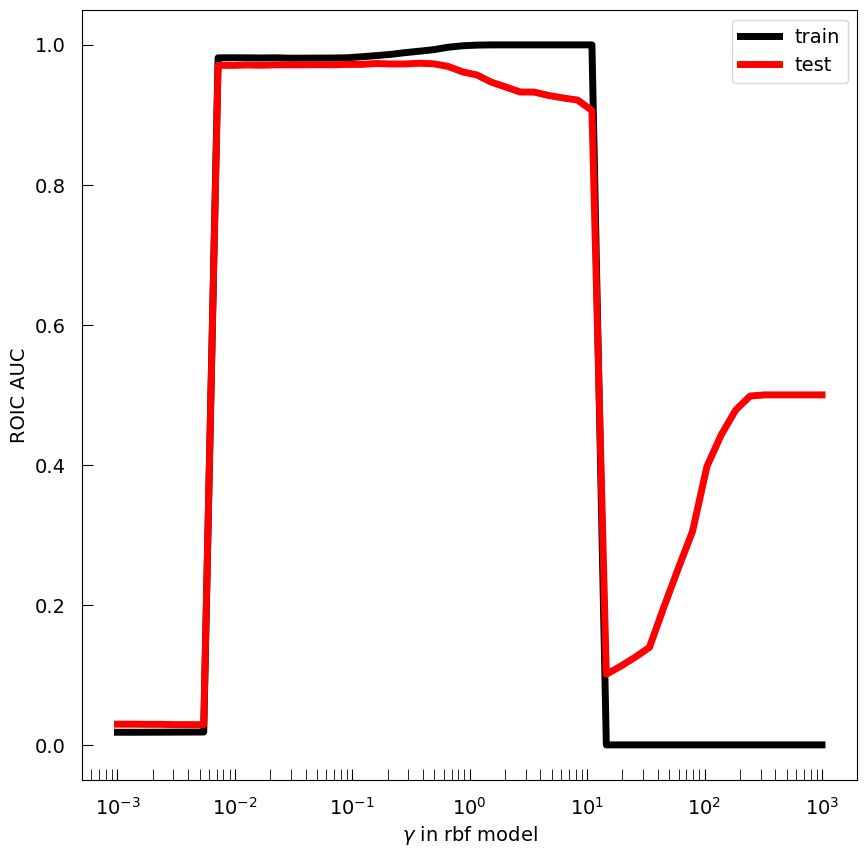

In [129]:
gamma_range=np.logspace(-3,3,50)

scores_test=[]
scores_train=[]

for k in gamma_range: 
    SVM_r = svm.SVC(C=k, kernel='rbf', gamma=k ,
                    class_weight='balanced', probability=True)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)

    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)
    
plt.figure()
plt.xlabel('$\gamma$ in rbf model')
plt.ylabel('ROIC AUC')
plt.plot(gamma_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(gamma_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

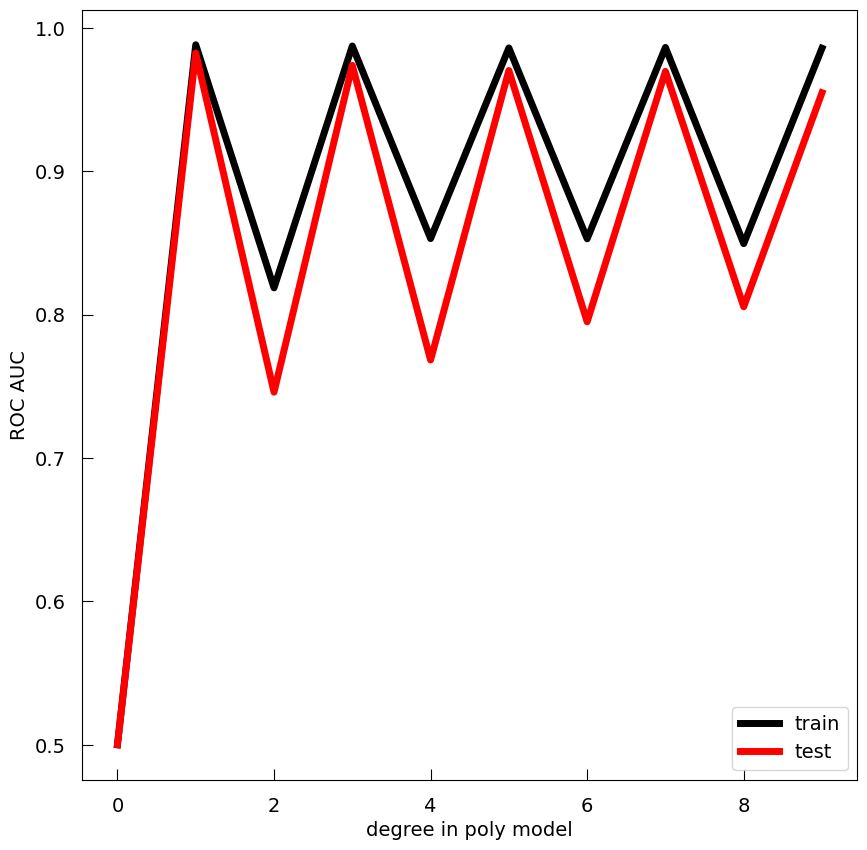

In [130]:
degree_range=np.arange(0,10,1)

scores_test=[]
scores_train=[]

for k in degree_range: 
    SVM_r = svm.SVC(C=1, kernel='poly', degree=k, 
                    probability=True, class_weight='balanced')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)

plt.figure()
plt.xlabel('degree in poly model')
plt.ylabel('ROC AUC')
plt.plot(degree_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(degree_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
#plt.xscale('log')
plt.legend(loc='best')
plt.show()

Those 3 hyperparameters show the usual overfitting behaviour when they are increased : monotonous increase of the accuracy on the train function whereas there is a maximum accuracy for the test function after which accuracy decreases with increasing hyperpaprameter value.

If you want to get the weights from the SVM just use `coef_` again but it will only work if you are in the context of a linear SVC.

# String kernels <a class="anchor" id="SVM-kernels"></a>

This paragraph illustrates how to use a SVM kernel not present in sklearn.svm. The following code uses the string kernel from [Hilmarsson et al. BioRxiv, 2021](https://doi.org/10.1101/2021.09.19.460980) in order to classify genomic sequences (here we use toy data based on patterns from real human samples). 

![Figure 2 of Hilmarsson et al. BioRxiv, 2021 : illustration of the string kernel computation](../images/stringKernel.png)

The code is copied from https://github.com/weekend37/string-kernels/blob/master/example.ipynb. More interesting examples can be found in the paper. First let's install the stringkernel package:

In [131]:
#to install string-kernel if that is not already done
#!python3 -m pip install string-kernels --upgrade

Let's load the data:

In [132]:
import os 

data_path = "../data"

samples_train = np.load(os.path.join(data_path, "samples_train"+".npy"))
samples_validation = np.load(os.path.join(data_path, "samples_validation"+".npy"))

ancestry_train = np.load(os.path.join(data_path, "ancestry_train"+".npy"))
ancestry_validation = np.load(os.path.join(data_path, "ancestry_validation"+".npy"))

reference = np.load(os.path.join(data_path, "reference"+".npy"))
populations = np.load(os.path.join(data_path, "populations"+".npy"))

print("number of training samples:", len(samples_train))
print("number of validation samples:", len(samples_validation))
print("Sequence length:", len(reference))
print("Number of ancestries:", len(populations))

number of training samples: 552
number of validation samples: 120
Sequence length: 1000
Number of ancestries: 6


The data matrix consists of arrays of nucleotides (rows), where each columns corresponds to a sequence position and each row to a sample.

In [133]:
samples_train

array([['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'A', 'A', ..., 'T', 'G', 'G'],
       ...,
       ['T', 'A', 'A', ..., 'T', 'C', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G']], dtype='<U1')

To use the standart SVM with RBF we need to turn the sequences into numeric values. For this example, we just store the information whether the sequences are the same (0) or different (1) from the reference sequence.

In [134]:
X_train = (samples_train != reference).astype(int)
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

The labels are balanced:

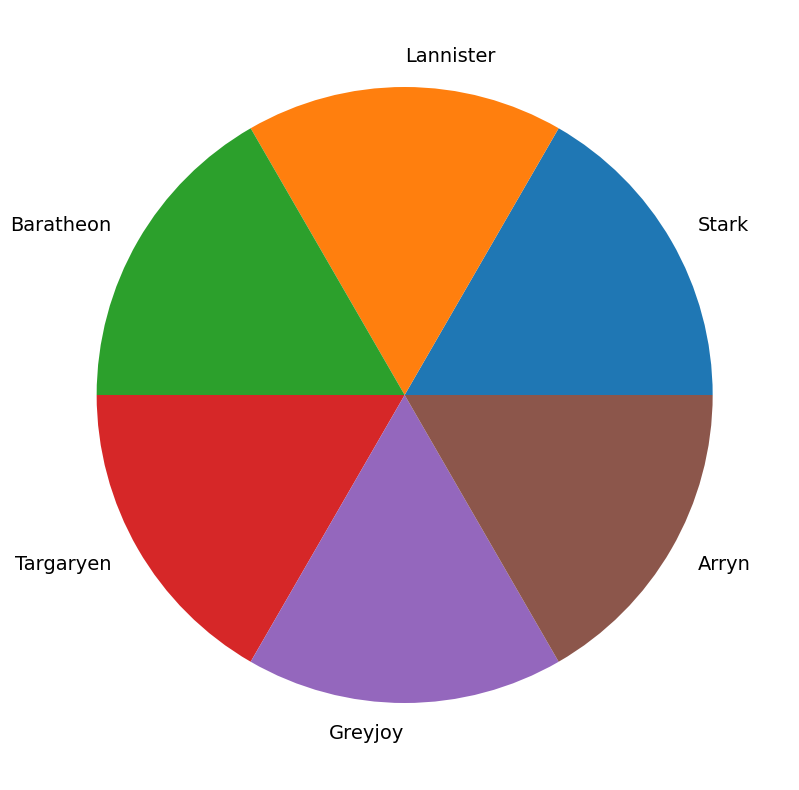

array(['Arryn', 'Baratheon', 'Greyjoy', 'Lannister', 'Stark', 'Targaryen'],
      dtype='<U9')

In [135]:
from stringkernels.utils import plot_label_distribution

plot_label_distribution(ancestry_train)
np.unique(ancestry_train)

The labels need to be turned into numbers in order to use the SVC class with RBF kernel:

In [136]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ancestry_train)
y_train = le.transform(ancestry_train)
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [137]:
X_val = (samples_validation != reference).astype(int)
y_val = le.transform(ancestry_validation)

In [138]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_accuracy*100, 2)))


Validation Accuracy: 59.17%


To use SVC with the string kernel we encountered in the lecture, we do not need the make the features numeric, but we can pass the string as character arrays directly:

In [139]:
from stringkernels.kernels import string_kernel

svm_sk_model = svm.SVC(kernel=string_kernel())
svm_sk_model.fit(samples_train, y_train)
y_pred = svm_sk_model.predict(samples_validation)
svm_sk_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_sk_accuracy*100, 2)))

Validation Accuracy: 69.17%


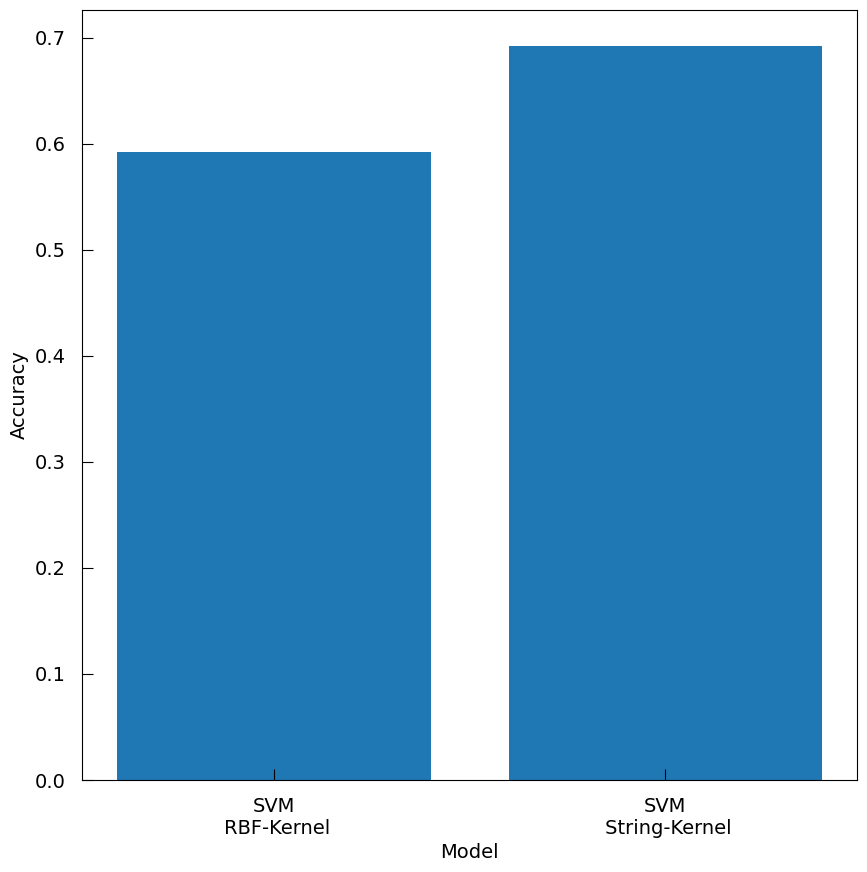

In [140]:
from stringkernels.utils import plot_accuracies

plot_accuracies({
    "SVM\n RBF-Kernel": svm_accuracy,
    "SVM\n String-Kernel": svm_sk_accuracy,
})

[Back to the ToC](#toc)

# Exercise <a class="anchor" id="exo"></a>


Using either the **cancer or the penguin dataset** compare and find the 'best' classifier. What do you learn from those classifiers? 

Don't forget that you have also seen stuff about preprocessing.

Don't go too crazy as it can be time consuming: limit the number of parameter values you are testing for.

**Hint :** before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. 
To adapt to multiple models, make a list of `grid_params` where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
*Example:*
``` python
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]
```

**Additionnal question** : How would you work with your PCA data and incorporate it to your model?

*Hint:* 
 * Don't forget that PCA needs a centering and a scaling step...
 * Adding PCA can be quite time consuming too. Try a small number of pca components first with other hyperparameters centered around what you found before!


In [141]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## PENGUIN CORRECTION

setup the pipeline and fit it :

In [142]:
# %load -r -24 solutions/solution_02_penguin.py

reporting best model:

In [143]:
# %load -r 25- solutions/solution_02_penguin.py

## CANCER CORRECTION 

build and fit the pipeline:

In [144]:
# %load -r -26 solutions/solution_02_cancer.py

report the best model:

In [145]:
# %load -r 28-45 solutions/solution_02_cancer.py

plot a roc curve:

In [146]:
# %load -r 46-47 solutions/solution_02_cancer.py

**Alternative with PCA:**

In [147]:
# %load -r 51-89 solutions/solution_02_cancer.py

In [148]:
# %load -r 90-104 solutions/solution_02_cancer.py

In [149]:
# %load -r 106- solutions/solution_02_cancer.py